# Recovery of gold from ore

Prepare a prototype of a machine learning model for the "RusGold". The company develops solutions for the efficient operation of industrial enterprises.

The model should predict the recovery rate of gold from gold-bearing ore. Use data with mining and cleaning parameters. 

The model will help optimize production so as not to launch an enterprise with unprofitable characteristics.

Stages of ore enrichment:<br>
**1. Flotation** <br>
A mixture of gold-bearing ore is fed into the flotation plant. After enrichment, a rough concentrate and "dump tails" are obtained, that is, product residues with a low concentration of valuable metals. The stability of this process is affected by the unstable and not optimal physico-chemical state of the flotation pulp (a mixture of solid particles and liquid).<br>
**2. Cleaning** <br>
The rough concentrate undergoes two purifications. At the output, the final concentrate and new dump tails are obtained.

**Technological process**<br>
* Rougher feed — feedstock
* Rougher additives (or reagent additives) — flotation
reagents: Xanthate, Sulfate, Depressant
- Xanthate **— xanthogenate (promoter, or flotation activator);
- Sulfate — sulfate (in this production sodium sulfide);
- Depressant — depressant (sodium silicate).
* Rougher process (English "rough process") — flotation
* Rougher tails — dump tails
* Float banks — flotation plant
* Cleaner process — cleaning
* Rougher Au — rough gold concentrate
* Final Au — final gold concentrate

**Stage parameters**<br>
* air amount — air volume
* fluid levels — liquid level
* feed size — the size of the raw material granules
* feed rate — feed rate

**Name of features**<br>
The name of the features should be as follows: [stage].[parameter type].[parameter name] <br>
Example: rougher.input.feed_ag <br>

Possible values for the [stage] block:
* rougher — flotation
* primary_cleaner — primary cleaning
* secondary_cleaner — secondary cleaning
* final — final characteristics

Possible values for the [parameter type] block:
* input — raw material parameters
* output — product parameters
* state — parameters characterizing the current state of the stage
* calculation — calculated characteristics

**Calculation of efficiency:**<br>
It is necessary to simulate the process of recovery of gold from gold-bearing ore.
*The enrichment efficiency is calculated by the formula:*

$$Recovery = \frac{C \times (F - T)}{F \times (C - T)} \times 100\%$$

*Where:*<br>
- C — the proportion of gold in the concentrate after flotation/purification;
- F — the proportion of gold in the raw material/concentrate before flotation/purification;
- T is the proportion of gold in the tailings after flotation/purification.
To predict the coefficient, you need to find the proportion of gold in concentrates and tailings. Moreover, not only the final product is important, but also the rough concentrate.<br>
**Quality metric:**<br>
To solve the problem, we introduce a new quality metric — sMAPE (English Symmetric Mean Absolute Percentage Error, "symmetric mean absolute percentage deviation").<br>
*Formula:*<br>

$$\mathit{sMAPE} = \frac{1}{N} \sum\limits _{i = 1} ^{N} \frac{\left| y_i - \hat{y}_i \right|}{\left( \left| y_i \right| + \left|\hat{y}_i \right| \right) / 2} \times 100\%$$

*Where:*<br>
- $y_i$ - The value of the target attribute for the object with the ordinal number i in the sample on which the quality is measured.
- $\hat{y}_i$ - Prediction value for an object with ordinal number i, for example, in a test sample.
- N - The number of objects in the selection.
- $\sum\limits _{i = 1} ^{N}$ - Summation over all objects of the sample (i varies from 1 to N).

It is necessary to predict two values at once:<br>
- the efficiency of enrichment of rough concentrate is rougher.conclusion.recovery;
- the final concentrate enrichment efficiency is final.conclusion.recovery.
The final metric consists of two values:<br><br>
$$\mathit{result_{MAPE}} = 25\%\times \mathit{sMAPE}_{ROUGHER} + 75\%\times \mathit{sMAPE}_{FINAL} $$

## ETL

In [1]:
# !pip install optuna

In [2]:
# !pip install imbalanced-learn --user

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
import seaborn as sns
import optuna

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn import FunctionSampler

from pylab import rcParams
from matplotlib.gridspec import GridSpec
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import (
    LinearRegression, LogisticRegression, HuberRegressor, PassiveAggressiveRegressor,
    ARDRegression, BayesianRidge, SGDRegressor, ElasticNet
)
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.impute import KNNImputer
from sklearn.ensemble import (
    RandomForestRegressor, 
    GradientBoostingRegressor, 
    BaggingRegressor,
    HistGradientBoostingRegressor,
    AdaBoostRegressor
)

from sklearn.tree import DecisionTreeRegressor

from scipy import stats as st
from numpy.random import RandomState

In [4]:
rcParams['figure.figsize'] = (12, 8)

pd.options.display.float_format = '{:,.3f}'.format
pd.options.display.max_columns = 100
pd.set_option('display.max_rows', 100)
pd.options.mode.chained_assignment = None

plt.rcParams['image.cmap'] = 'Set2'
plt.set_cmap("Set2");

sns.set_style("whitegrid", {'figure.facecolor': '0.97'});
sns.set_palette("Set2");

RANDOM_STATE = 12345

<Figure size 864x576 with 0 Axes>

In [5]:
def corr_triag_heatmap(corr, title_str):
    '''
    Function to draw triangle heatmap matrix (without diagonal elements)
    :param corr: correlation table
    :param title_str: plot title string
    '''
    # mask = np.zeros_like(corr)
    # mask[np.triu_indices_from(mask)] = True
    mask = np.triu(np.full(corr.shape, True))
    corr = corr.iloc[1:, :-1]
    mask = pd.DataFrame(mask).iloc[1:, :-1].to_numpy()

    # heatmap
    plt.figure(figsize=(corr.shape[0] * 1.2, (corr.shape[0] * 0.6)))
    ax = sns.heatmap(corr, annot=True, cmap="RdBu", mask=mask, vmin=-1, vmax=1)
    ax.set_title(title_str, fontdict={'fontsize':14})
    plt.show()

def sub_hist_and_boxplot(df, col, subfig, iqr=3, seaborn_hist=True):
    '''
    accessory plot  for plotting axes on subfigure
    :param df: DataFrame
    :param col: column name for plotting
    :param subfig: object Figure
    '''
    subfig.suptitle(col, fontsize=12)
    
    
    if df[col].dtype in [np.dtype('float64'), np.dtype('int64'), np.dtype('uint8')]:
        ax = subfig.subplots(nrows=2,ncols=1, sharex=True, gridspec_kw={'height_ratios': [10, 1.5], 'wspace':0, 'hspace': 0})
        if not seaborn_hist:
            df.hist(column=col, bins=80, ax=ax[0])
        else:
            sns.histplot(data=df, x=col, ax=ax[0])
        ax[0].set_title(None)
        b = df.boxplot(column=col, widths=0.5, vert=False, showcaps=True, whis=iqr, ax=ax[1],  
                       flierprops={'marker': '|', 'markersize': 15, 'markeredgecolor': 'g', 'markeredgewidth':2, 'zorder':1},
                       capprops={'color':'r', "linewidth": 2, 'zorder':3}, return_type='dict')
        ax[1].set_yticklabels([])
        ax[1].grid(visible=False, axis='both')
        ax[0].grid(visible=True, axis='y')
        
    elif df[col].dtype == np.dtype('<M8[ns]'):
        ax = subfig.subplots(nrows=1,ncols=1)
        if not seaborn_hist:
            df.hist(column=col, bins=80, ax=ax)
        else:
            sns.histplot(data=df, x=col, ax=ax)
        ax.grid(visible=True, axis='y')
        ax.tick_params(axis='x', labelrotation=30)
        ax.set_title(None)
    elif df[col].dtype == np.dtype('O'):
        ax = subfig.subplots(nrows=1,ncols=1)
        s = df[col].value_counts()
        if s[15:].sum() >0:
            t = pd.concat([s[:15], pd.Series(index=['_other_'], data=[s[15:].sum()])]).reset_index()
        else:
            t = s.copy().reset_index()
        t.columns = ['cat_name', 'count']
        ax.pie(t['count'], labels=t['cat_name'], autopct='%1.1f%%');
    else:
        ax = subfig.subplots(nrows=1,ncols=1)
    return subfig, ax

def hist_and_boxplot(data, col, iqr=3, figsize=(16, 8)):
    '''
    plot histplot with boxplot for data overall view
    :param data: pandas DataFrame
    :param col: name of column with data to evaluate
    :param iqr: koefficient in IQR approach to detect fliers (UBound = Q75 + iqr * (Q75-Q25))
    :param figsize: touple
    :return: fliers
    '''
    fig, ax = plt.subplots(figsize=figsize , nrows=2,ncols=1, sharex=True, gridspec_kw={'height_ratios': [10, 1.5]})
    fig.suptitle(col, fontsize=16)
    # fig.set_size_inches(12, 8)
    data[col].hist(bins=80, ax=ax[0])
    
    stat = data[col].describe()

    b = data.boxplot(column=col, widths=0.5, vert=False, showcaps=True, whis=iqr, ax=ax[1], 
                     flierprops={'marker': '|', 'markersize': 15, 'markeredgecolor': 'g', 'markeredgewidth':2, 'zorder':1},
                     capprops={'color':'r', "linewidth": 2, 'zorder':3}, return_type='dict')
    ax[1].set_yticklabels([''])
    ax[1].grid(visible=False, axis='both')
    fliers = b['fliers'][0].get_xdata()
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    fig.text(
        0.047,
        0.915,
        f"count: {stat['count']:,.0f} \
    fliers: {fliers.shape[0]} ({sum(fliers<stat['50%'])}, {sum(fliers>stat['50%'])}) \
    median: {b['medians'][0].get_xdata()[0]} \
    mean: {stat['mean']:.1f} \
    caps: [{b['caps'][0].get_xdata()[0]}, {b['caps'][1].get_xdata()[0]}] \
    box: [{b['boxes'][0].get_xdata()[0]}, {b['boxes'][0].get_xdata()[2]}] \
    min max: [{stat['min']:.1f}, {stat['max']:.1f}]",
        ha="left",
#             color='w',
        fontname="DejaVu Sans",
        fontsize=12,
        )
    plt.show()
    return fliers



def evaluate_df(
    df, title="", 
    show_corr_zero_plots = False, 
    show_corr_null_plots=False, 
    show_scatter_matrix=False, 
    show_histograms=False, 
    show_histograms_box=True):
    '''
    Function for dataframe evaluation
      1) show sample
      2) show data types in columns
      3) show count NaN and zeros
      4) correlation zeros at the same objects in different columns
      5) correlation NaNs at the same objects in different columns
      6) scatter_matrix
    :param df: pandas DataFrame
    :param show_corr_zero_plots: 
    :param show_corr_null_plots: 
    :param show_scatter_matrix: 
    '''
    print(''.ljust(96, '-'))
    s='---   ' + title + '   '
    print(s.ljust(96, '-'))
    print(''.ljust(96, '-'))
    
    print('\nComplete duplicates:', df.duplicated().sum())
    print('Empty cells:', df.isna().sum().sum())
    
    
    print('\n------SAMPLE--------')
    display(df.sample(min(5,len(df))))
    print('\n------DTYPES--------')
    print(df.dtypes)

    # count NaN
    print('\n\n------NaN & zero--------')
    na = pd.DataFrame(index=df.columns
                      , data={
                          'NA':df.isna().sum().values
                          , 'filled': df.notna().sum().values
                          , 'zero':df.eq(0).sum()
                      }
                     )
    na['%na'] = na['NA']/len(df)*100
    print(na.replace(0,'-'))
    
    
    
    if show_corr_zero_plots:
        # correlation matrix of zeros
        t = df.eq(0).sum().sort_values()
        indx = t[t > 0].index
        if len(indx) > 1:
            print()
            corr = df[indx].isin([0,'0']).corr()
            corr_triag_heatmap(corr, "Correlation of ZEROs in columns")
            
            # Add map of zeros
            t = df[indx].eq(0).sort_values(by=list(indx))
            plt.figure(figsize = (20,len(indx)*0.6))
            
            ax = sns.heatmap(t.transpose(), alpha=0.4,cbar_kws = {"ticks":[False, True], "drawedges":True}, cmap=sns.color_palette(['#00AA00', '#FF4444']))
            ax.set_title("Map of ZEROs values", fontdict={'fontsize':14})
            ax.hlines(ax.yaxis.get_ticklocs() + 0.5, 0, t.shape[0], color='w', linewidths=1)
            plt.show()
    if show_corr_null_plots:
        # correlation matrix of NaN
        t = df.isna().sum().sort_values()
        indx = t[t > 0].index
        if len(indx) > 1:
            print()
            corr = df[indx].isna().corr()
            corr_triag_heatmap(corr, "Correlation of NULL in columns")
            
            # Add map of NaN
            t = df[indx].isna().sort_values(by=list(indx))
            plt.figure(figsize = (20,len(indx)*0.6))
            
            ax = sns.heatmap(t.transpose(), alpha=0.4,cbar_kws = {"ticks":[False, True], "drawedges":True}, cmap=sns.color_palette(['#00AA00', '#FF4444']))
            ax.set_title("Map of NULL values", fontdict={'fontsize':14})
            ax.hlines(ax.yaxis.get_ticklocs() + 0.5, 0, t.shape[0], color='w', linewidths=1)
            plt.show()

#     display(df.describe(include='all').transpose())
    print('\n\n------ describe --------')
    if np.dtype('int64') in df.dtypes.values or np.dtype('float64') in df.dtypes.values:
        print('\n\tNumeric')
        display(df.describe(include=[np.number]).transpose())
    if np.dtype('<M8[ns]') in df.dtypes.values:
        print('\n\tDateTime')
        display(df.describe(include=['datetime'], datetime_is_numeric=True).transpose())
    
#     print('\n\tCategory')
#     display(df.describe(include=['category']).transpose())
    
    if np.dtype('O') in df.dtypes.values:
        print("\n\tText (object)")
        df_o = df.describe(include=[object]).transpose()
        display(df_o)
        for col in df_o.index:
            uniq_cnt = df_o.loc[col, "unique"]
            print("\n  Unique:", uniq_cnt)
            if 15<uniq_cnt < 300:
                print(f'\n{col} unique: {uniq_cnt}\n', df[col].sort_values().unique())
            s = df[col].value_counts()
            display(pd.concat([s[:15], pd.Series(index=['_other_'], data=[s[15:].sum()])]))
            
    
    if show_scatter_matrix:
        pd.plotting.scatter_matrix(df, figsize=(16,10), alpha=0.1, s=5);
    
    if show_histograms:
        cols_no = 2
        rows_no = (len(df.columns) - 1)//cols_no +1 # number rows

        # plot hostograms for numeric features and pie charts for categorial
        fig, ax = plt.subplots(nrows=rows_no, ncols=cols_no, layout="constrained", squeeze = False)
        fig.set_figheight(3 * rows_no)
        fig.set_figwidth(4 * cols_no)

        for i in range(len(df.columns)):
            r = i // cols_no
            c = i - r * cols_no
            col = df.columns[r*cols_no + c]
            if df[col].dtype in [np.dtype('float64'), np.dtype('int64'), np.dtype('<M8[ns]')]:
                ax[r,c].hist(df[col])
                ax[r,c].set_title(col)
                if df[col].dtype == np.dtype('<M8[ns]'):
                    ax[r,c].tick_params(axis='x', labelrotation=30)
            elif df[col].dtype == np.dtype('O'):
                t = df[col].value_counts().reset_index()
                t.columns = ['cat_name', 'count']
                ax[r,c].pie(t['count'], labels=t['cat_name'], autopct='%1.1f%%');
                ax[r,c].set_title(col)

        if c != cols_no:
            for c_ in range(c+1, cols_no, 1):
                ax[r,c_].axis('off')
        plt.show()
    if show_histograms_box:
        list_col = df.columns
        cols_no = 2
        rows_no = (len(list_col) - 1)//cols_no +1 # number rows

        fig = plt.figure(constrained_layout=True, figsize=(4*cols_no,rows_no*3))
        fig.suptitle('Histograms', fontsize=16)
        subfigs = fig.subfigures(rows_no, cols_no)


        for outerind, subfig in enumerate(subfigs.flat):
            if outerind < len(list_col):
                col = list_col[outerind]
                sub_hist_and_boxplot(df, col, subfig, seaborn_hist=False)

        plt.show()

In [6]:
df_train = pd.read_csv('../../datasets/gold_recovery_train_new.csv', sep=',', parse_dates=[0])
df_test = pd.read_csv('../../datasets/gold_recovery_test_new.csv', sep=',', parse_dates=[0])
df_full = pd.read_csv('../../datasets/gold_recovery_full_new.csv', sep=',', parse_dates=[0])

In [7]:
def na0(df):
    '''
    Calculate number of zeros and NaNs in DataFrame
    '''
    return [df.eq(0).sum().sum(), df.isna().sum().sum(), df.shape]

In [8]:
displ=[]
for df in df_train, df_test, df_full:
    displ.append(na0(df)) 
pd.DataFrame(displ, columns=['zeros', 'NaN', 'shape'])

,zeros,NaN,shape
0,5621,4100,"(14149, 87)"
1,1,90,"(5290, 53)"
2,7171,4481,"(19439, 87)"


------------------------------------------------------------------------------------------------
---   FULL dataset   ---------------------------------------------------------------------------
------------------------------------------------------------------------------------------------

Complete duplicates: 0
Empty cells: 4481

------SAMPLE--------


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
17358,2018-05-06 05:59:59,4.556,8.953,5.946,40.312,69.441,9.760,2.056,6.115,1.868,64.224,6.053,7.050,0.694,6.249,8.473,5.378,31.224,17.340,3.548,6.136,1.491,"1,699.219",-500.307,"1,698.734",-499.438,"1,698.508",-500.491,"1,697.566",-499.548,"47,068.717","2,498.924","2,498.719",2.051,6.813,2.697,314.138,47.087,25.805,5.531,4.138,5.101,4.138,5.104,11.251,7.761,25.359,18.927,80.273,4.151,0.282,12.693,1.426,"1,200.622",-300.053,"1,299.423",-499.510,"1,197.365",-499.429,"1,198.563",-500.853,"1,097.650",-500.247,"1,098.268",-497.228,17.645,8.368,NaN,3.184,34.921,-500.201,28.034,-500.447,35.998,-500.052,25.018,-500.036,30.018,-507.913,19.855,-330.848,24.970,-500.691,23.018,-500.248,25.010,-500.191
9017,2017-03-23 12:59:59,4.967,9.167,9.635,47.387,65.436,9.878,3.019,10.499,3.256,125.329,7.496,7.040,0.763,7.557,8.713,7.066,35.690,15.152,2.828,8.937,3.255,"1,698.640",-500.023,"1,694.316",-500.138,"1,698.140",-499.936,"1,699.391",-499.258,"43,234.827","3,786.289","3,786.273",2.643,9.118,3.154,378.553,49.096,38.260,8.336,12.588,5.502,12.589,5.501,11.658,6.625,28.853,2


------DTYPES--------
date                                                  datetime64[ns]
final.output.concentrate_ag                                  float64
final.output.concentrate_pb                                  float64
final.output.concentrate_sol                                 float64
final.output.concentrate_au                                  float64
final.output.recovery                                        float64
final.output.tail_ag                                         float64
final.output.tail_pb                                         float64
final.output.tail_sol                                        float64
final.output.tail_au                                         float64
primary_cleaner.input.sulfate                                float64
primary_cleaner.input.depressant                             float64
primary_cleaner.input.feed_size                              float64
primary_cleaner.input.xanthate                               float64
primary_clea

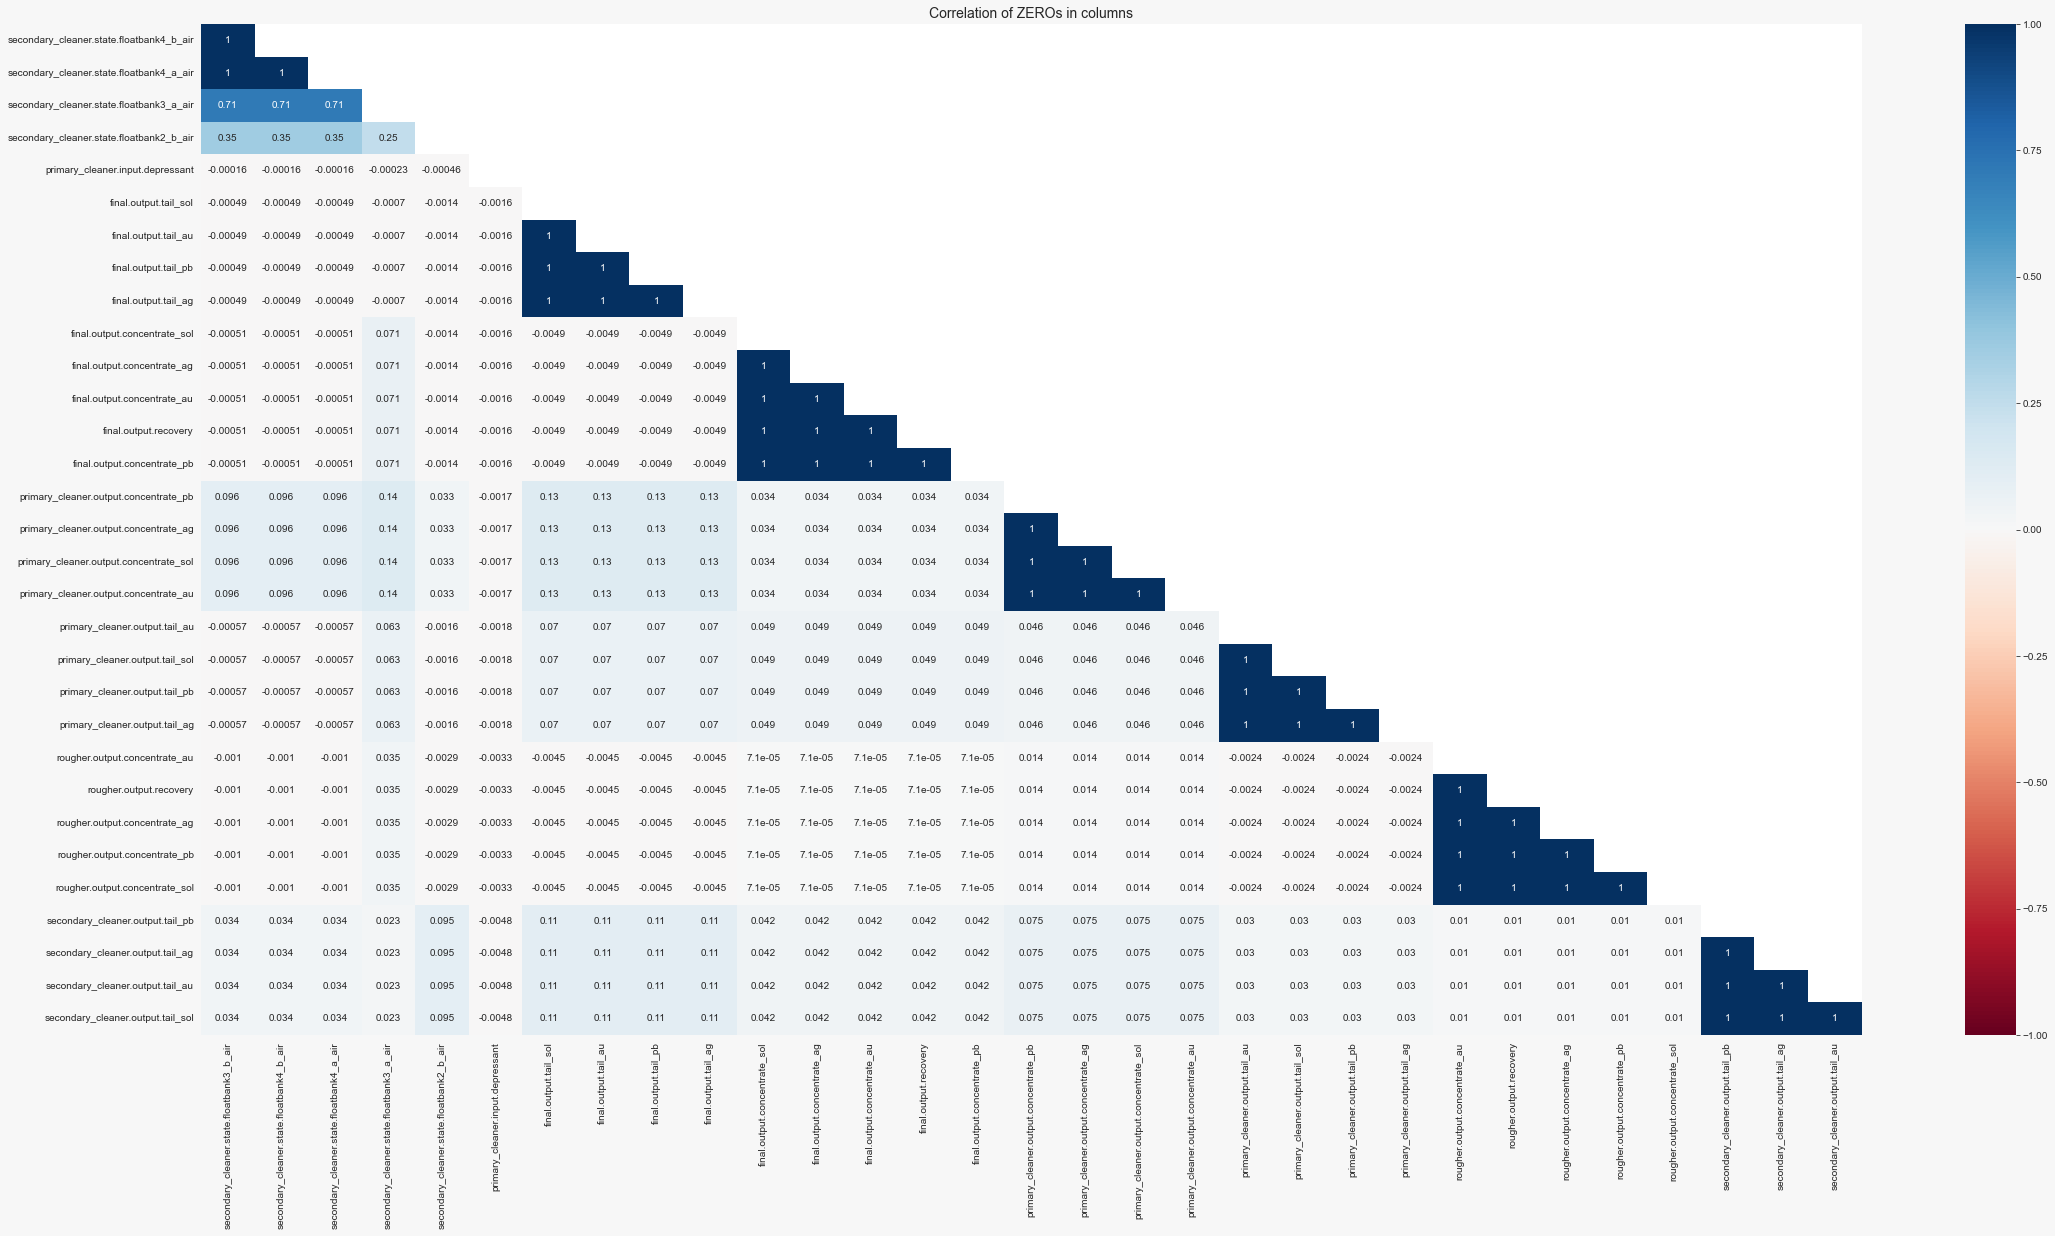

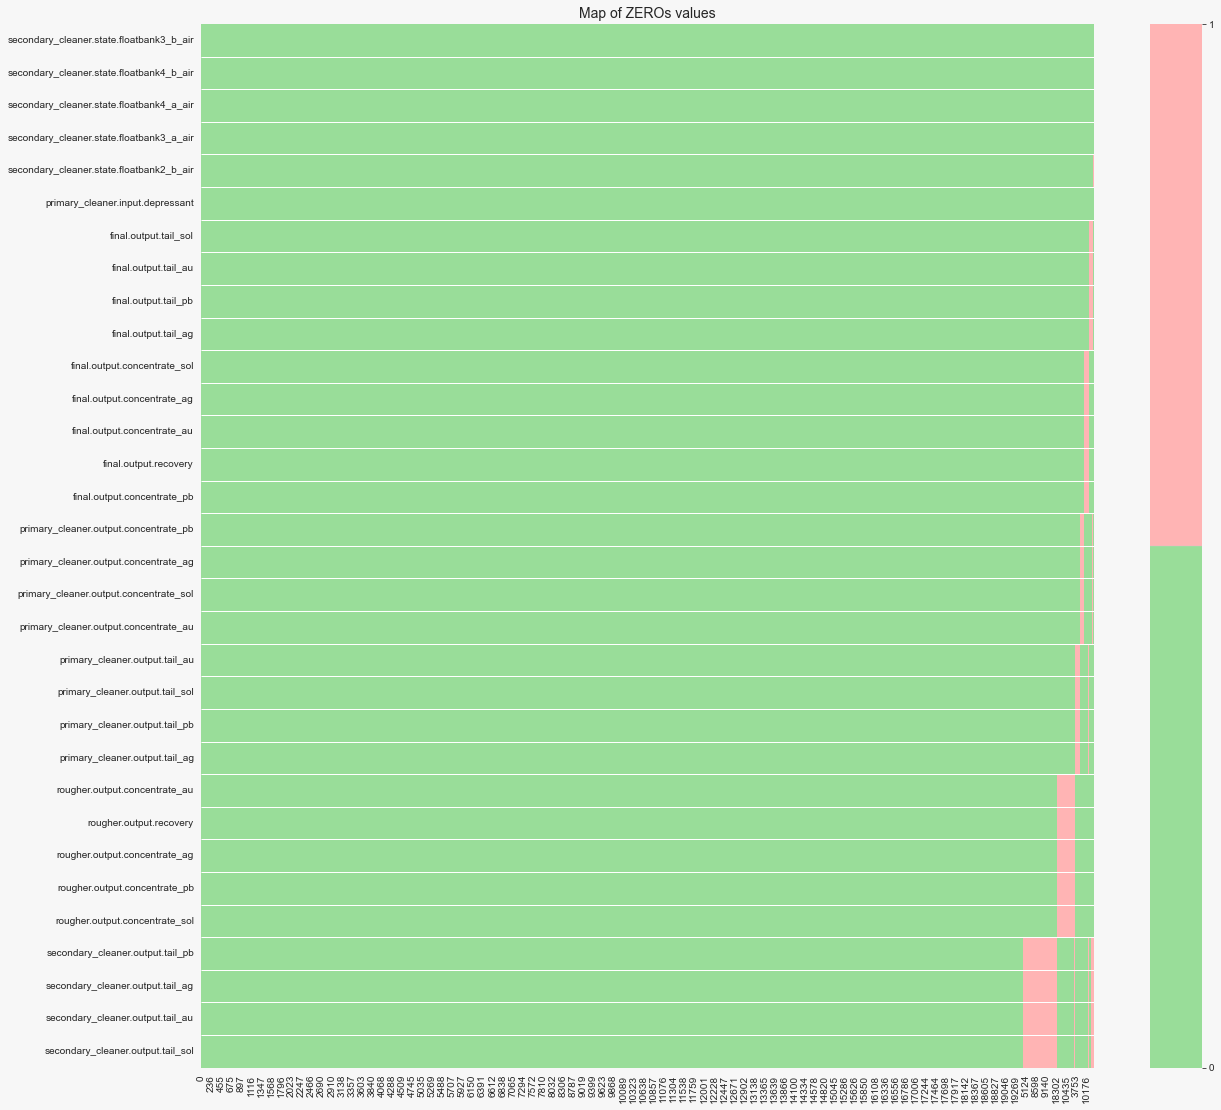

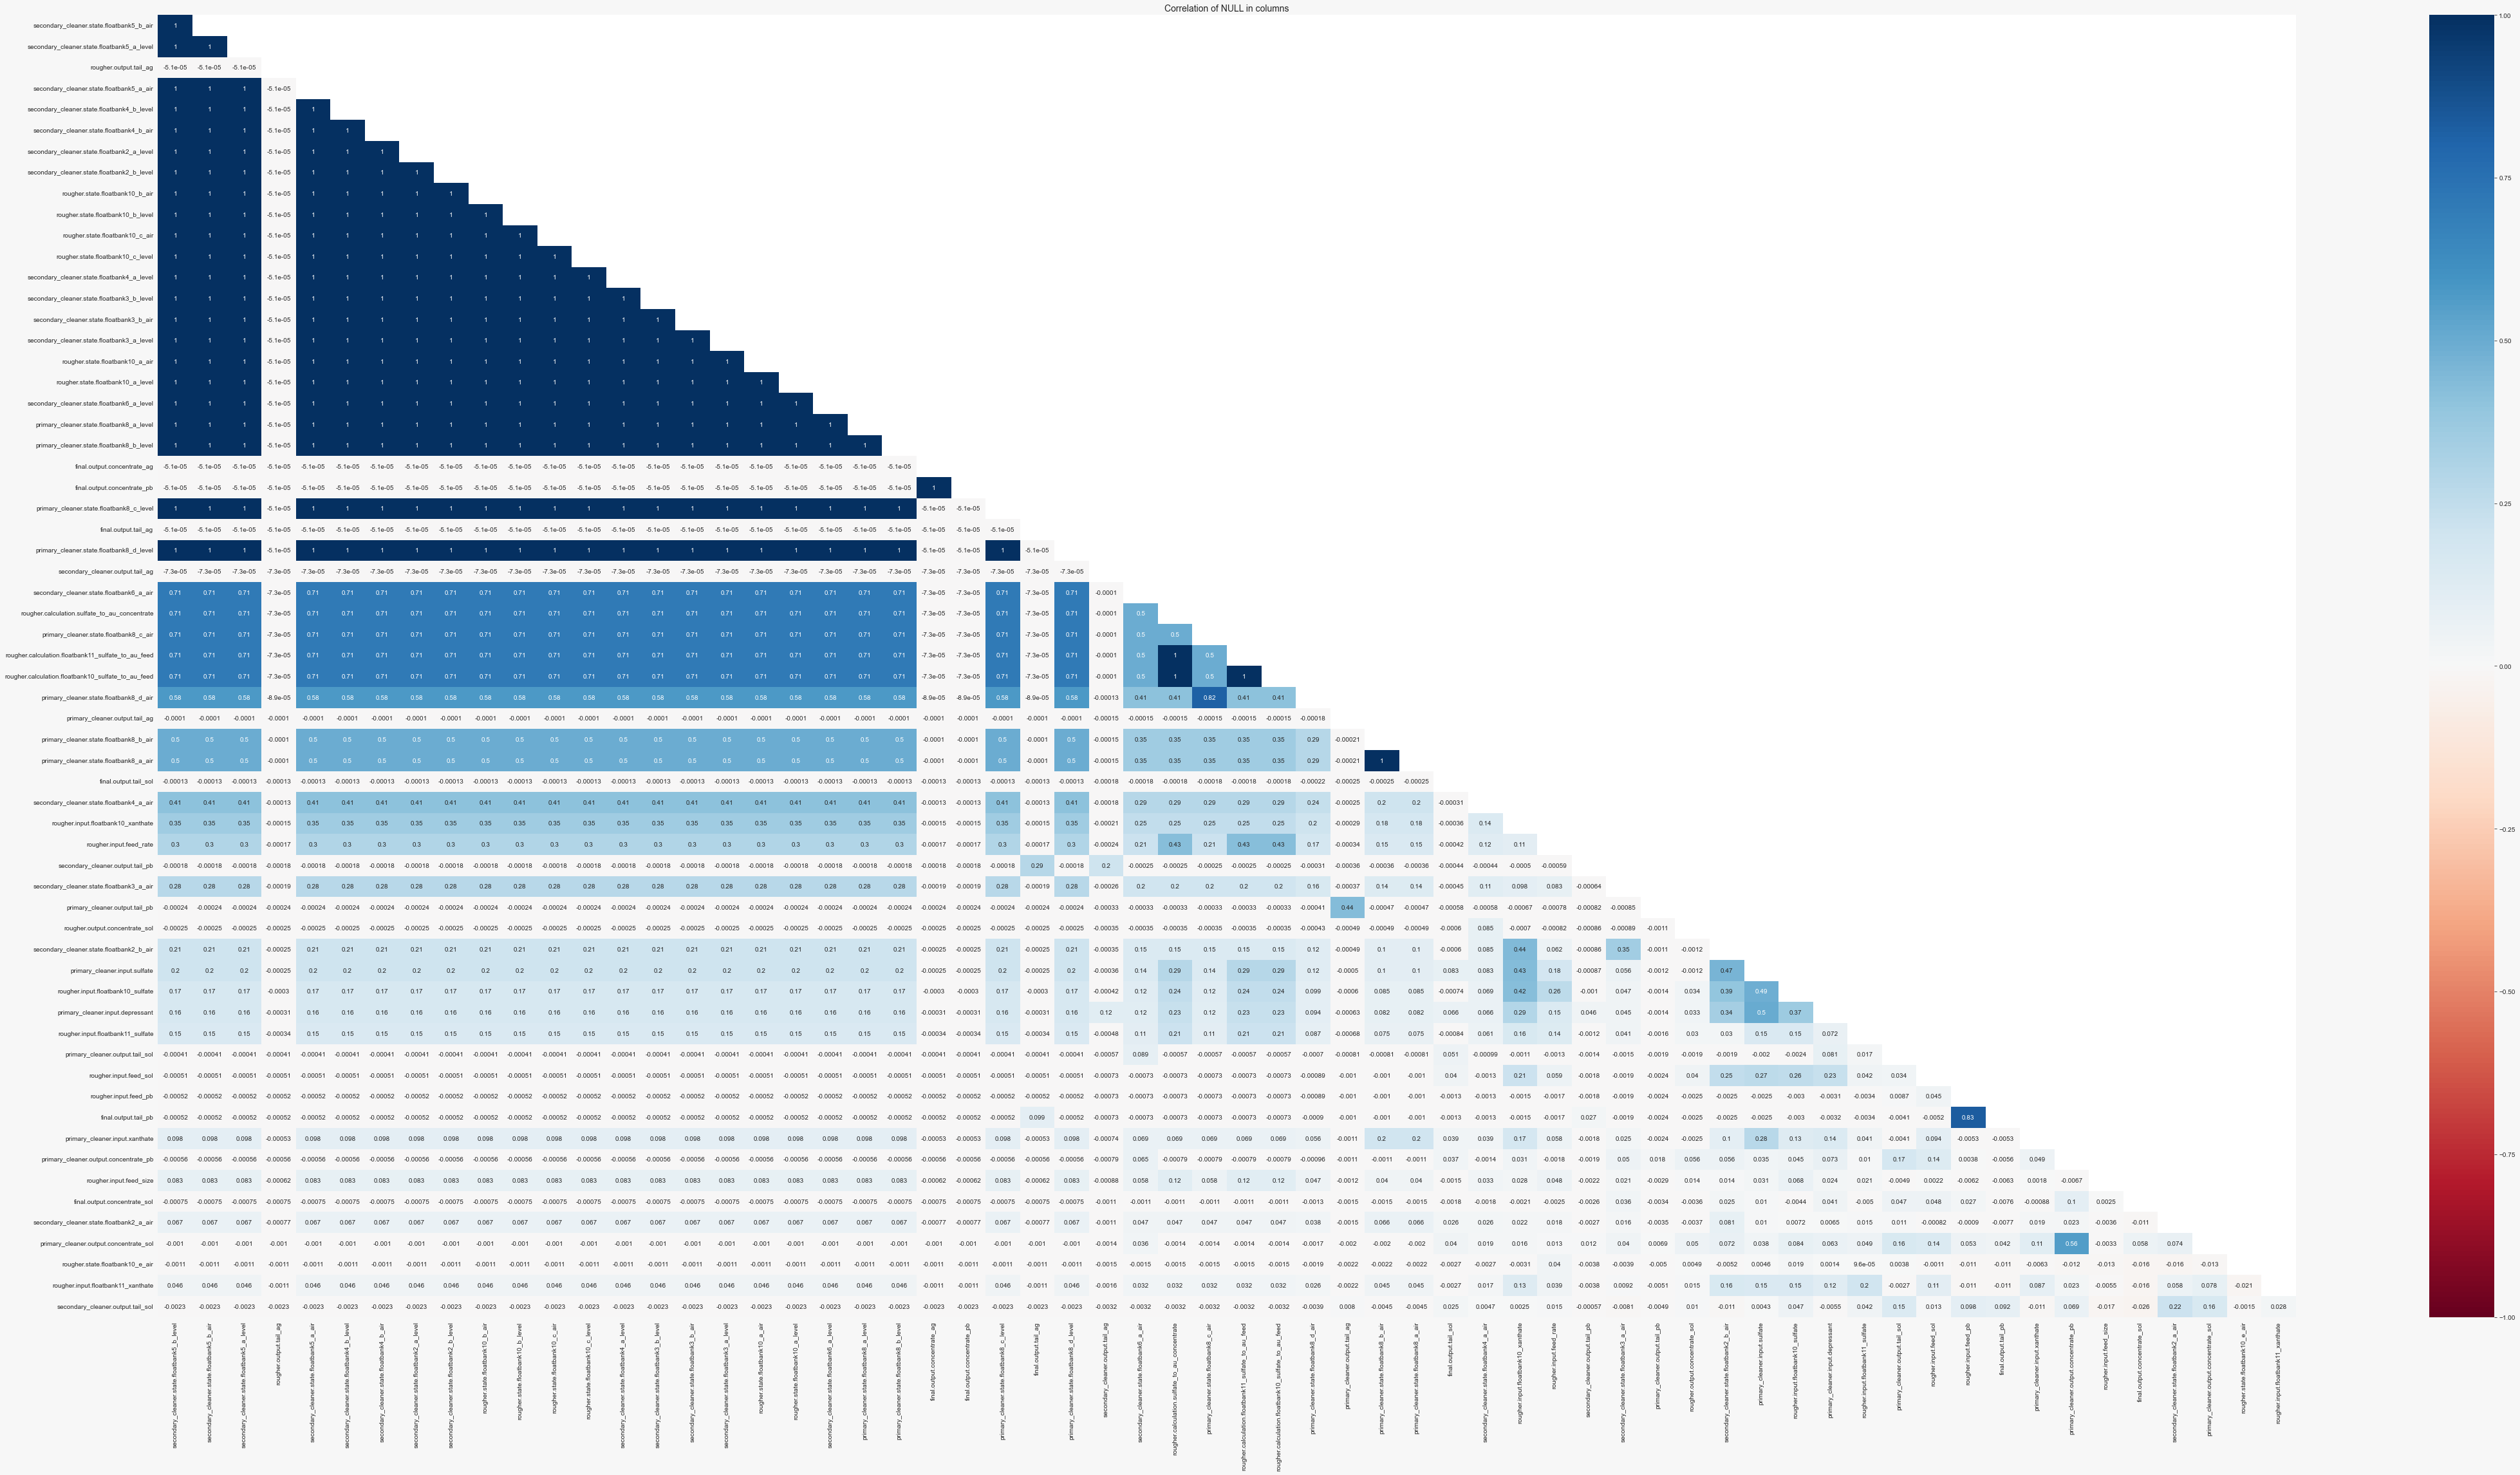

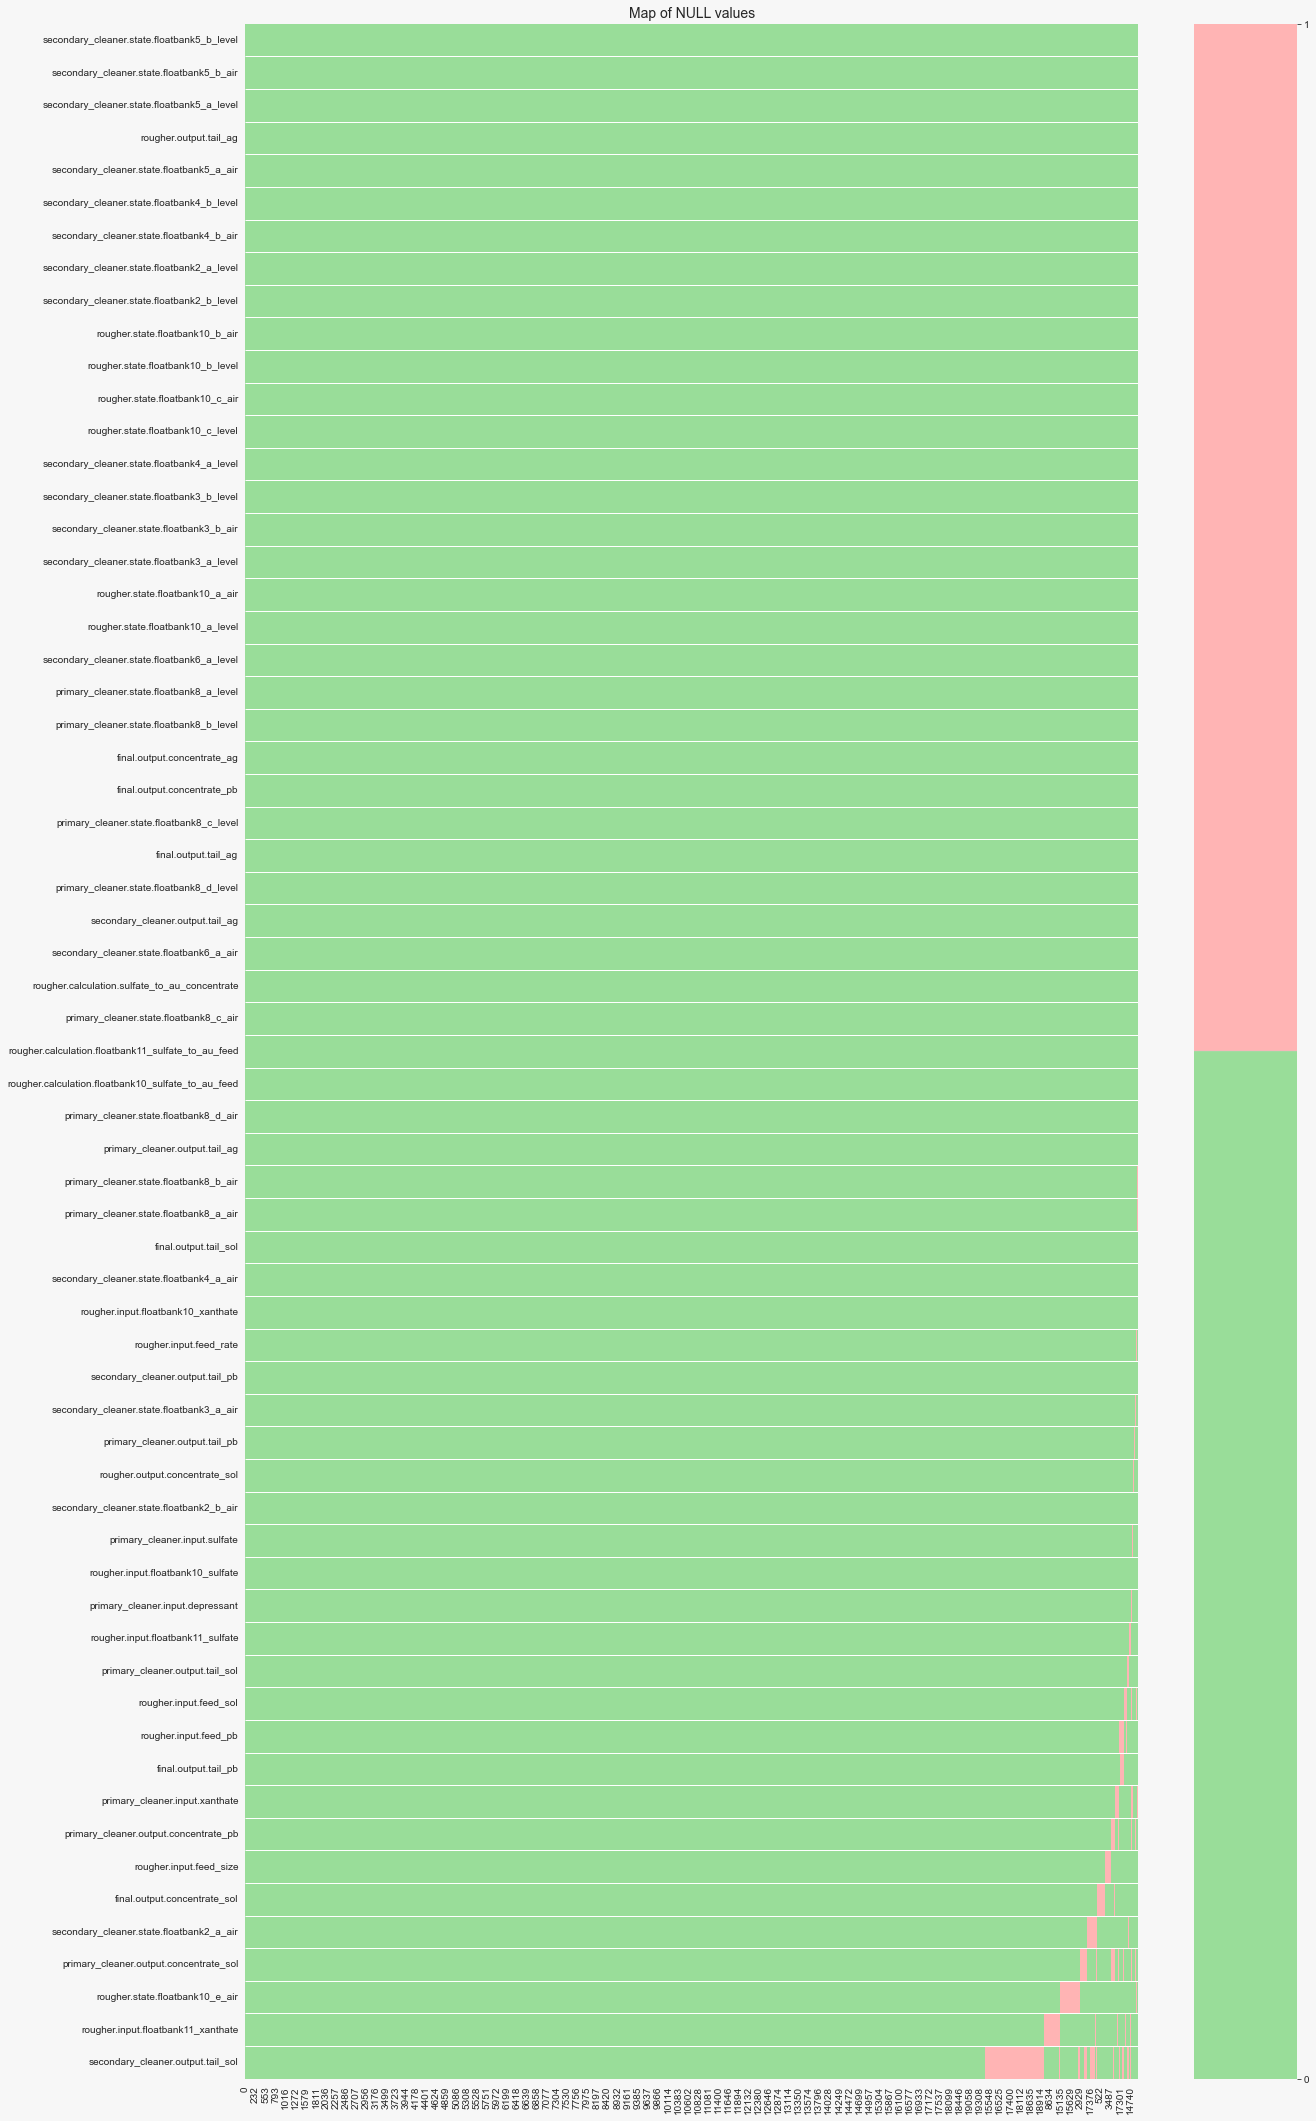



------ describe --------

	Numeric


,count,mean,std,min,25%,50%,75%,max
final.output.concentrate_ag,"19,438.000",5.168,1.372,0.000,4.251,5.066,5.896,16.002
final.output.concentrate_pb,"19,438.000",9.979,1.669,0.000,9.137,10.102,11.036,17.032
final.output.concentrate_sol,"19,228.000",9.501,2.788,0.000,7.723,9.219,10.948,19.616
final.output.concentrate_au,"19,439.000",44.077,5.130,0.000,43.402,45.011,46.275,52.757
final.output.recovery,"19,439.000",67.050,10.126,0.000,63.300,68.173,72.687,100.000
final.output.tail_ag,"19,438.000",9.689,2.329,0.000,8.063,9.744,11.134,19.552
final.output.tail_pb,"19,338.000",2.706,0.949,0.000,2.040,2.749,3.333,5.804
final.output.tail_sol,"19,433.000",10.584,2.869,0.000,8.939,10.622,12.104,22.318
final.output.tail_au,"19,439.000",3.042,0.923,0.000,2.461,2.985,3.571,8.245
primary_cleaner.input.sulfate,"19,415.000",144.625,44.464,0.003,114.107,143.232,175.076,265.983



	DateTime


,count,mean,min,25%,50%,75%,max
date,19439,2017-04-30 01:59:24.284531200,2016-01-15,2016-09-08 18:59:59,2017-04-25 17:59:59,2017-12-09 14:29:59,2018-08-18 10:59:59


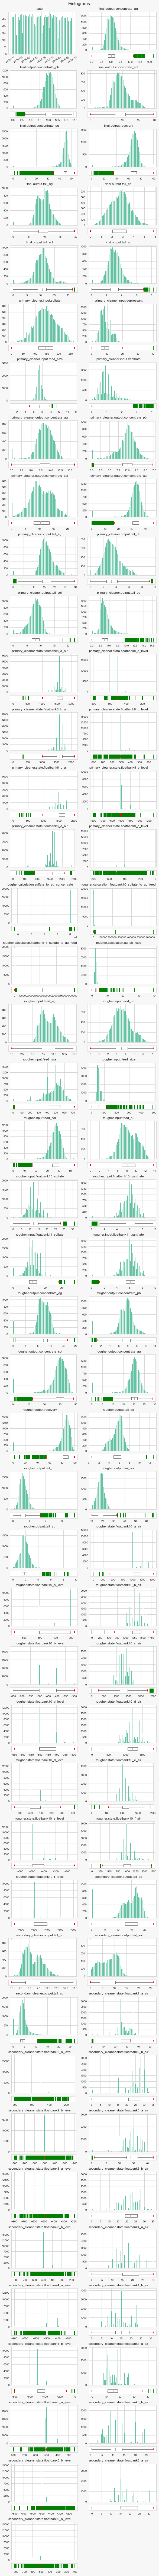

In [9]:
evaluate_df(df_full, title='FULL dataset' , show_corr_zero_plots=True, show_corr_null_plots=True)

In [10]:


def calc_bounds_outliers(df, column, mode='iqr', k_lbound=1.5, k_ubound=1.5):
    '''
    A function for determining outliers (using the IQR or 3s method) and removing them.
    The column is analyzed and the distribution of values is looked at and outliers are removed
    '''
    t1 = df[column].describe()
    if mode == 'iqr':
        iqr = t1['75%']-t1['25%']
        l_bound = max(t1['25%'] - iqr*k_lbound, t1['min'])
        u_bound = min(t1['75%'] + iqr*k_ubound, t1['max'])
    else:
        l_bound = t1['mean'] - 3*t1['std']
        u_bound = t1['mean'] + 3*t1['std']
    
    return l_bound, u_bound


def delete_outliers(df, column, mode='iqr', k_lbound=1.5, k_ubound=1.5):
    '''
    Function for deleting rows with outliers
    The column is analyzed and the distribution of values is looked at and outliers are removed
    '''
    
    l_bound, u_bound = calc_bounds_outliers(df, column, mode, k_lbound, k_ubound)

    print('\n' + column + ' ')
    print(f'bounds are:({l_bound:.2f},{u_bound:.2f})')
    b = len(df)
    df = df.loc[(df[column] <= u_bound) & (l_bound <= df[column])]
    print(f'Deleted:{(b-len(df))} ({(b-len(df))/b:.1%})')
    
    return df


def set_outliers_as_nan(df, column, mode='iqr', k_lbound=1.5, k_ubound=1.5):
    '''
    Function to replace rows with outliers with NaN
    The column column is analyzed and the distribution of values is looked at and outliers are replaced with NaN
    '''
    l_bound, u_bound = calc_bounds_outliers(df, column, mode, k_lbound, k_ubound)
    df.loc[(df[column] >= u_bound) & (l_bound <= df[column])] = np.nan
    return df


We see that there are a lot of outliers in the data, there are a lot of NaNs, there are zero concentrations. It is necessary to provide for the possibility of removing outliers from features.This could improve the model

### Checking the calculation of ore dressing efficiency rougher.output.recovery

In [11]:
C = df['rougher.output.concentrate_au']
F = df['rougher.input.feed_au']
T = df['rougher.output.tail_au']

recovery_rough = C * (F-T) / (F * (C-T))*100
MAE = mean_absolute_error(recovery_rough, df['rougher.output.recovery'])
MAE


9.874045668302637e-15

#### Conclusions

The column rougher.output.recovery completely coincides with the value calculated independently. The deviation of 9.73512347450521e-15 can be explained by the limit of accuracy of floating-point calculations in python

### Features not available in the test set

In [12]:
list(df_train.columns.difference(df_test.columns))

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

#### Conclusions

These parameters describe the process parameters C (concentrate) and T (tail) after the rougher stage.
there are also no 4 calculation columns

These parameters contain information about key features and their use will lead to data leakage, so they are removed from test, everything is correct

### Preprocessing

Set columns for predicting target features at the rougher and final stages

In [13]:
X_cols = {
    'rougher': [
        'rougher.input.feed_ag',
        'rougher.input.feed_pb',
        'rougher.input.feed_rate',
        'rougher.input.feed_size',
        'rougher.input.feed_sol',
        'rougher.input.feed_au',
        'rougher.input.floatbank10_sulfate',
        'rougher.input.floatbank10_xanthate',
        'rougher.input.floatbank11_sulfate',
        'rougher.input.floatbank11_xanthate',
        'rougher.state.floatbank10_a_air',
        'rougher.state.floatbank10_a_level',
        'rougher.state.floatbank10_b_air',
        'rougher.state.floatbank10_b_level',
        'rougher.state.floatbank10_c_air',
        'rougher.state.floatbank10_c_level',
        'rougher.state.floatbank10_d_air',
        'rougher.state.floatbank10_d_level',
        'rougher.state.floatbank10_e_air',
        'rougher.state.floatbank10_e_level',
        'rougher.state.floatbank10_f_air',
        'rougher.state.floatbank10_f_level'
    ],
    'final': [
        'primary_cleaner.input.sulfate',
        'primary_cleaner.input.depressant',
        'primary_cleaner.input.feed_size',
        'primary_cleaner.input.xanthate',
        'primary_cleaner.state.floatbank8_a_air',
        'primary_cleaner.state.floatbank8_a_level',
        'primary_cleaner.state.floatbank8_b_air',
        'primary_cleaner.state.floatbank8_b_level',
        'primary_cleaner.state.floatbank8_c_air',
        'primary_cleaner.state.floatbank8_c_level',
        'primary_cleaner.state.floatbank8_d_air',
        'primary_cleaner.state.floatbank8_d_level',
        'rougher.input.feed_ag',
        'rougher.input.feed_pb',
        'rougher.input.feed_rate',
        'rougher.input.feed_size',
        'rougher.input.feed_sol',
        'rougher.input.feed_au',
        'rougher.input.floatbank10_sulfate',
        'rougher.input.floatbank10_xanthate',
        'rougher.input.floatbank11_sulfate',
        'rougher.input.floatbank11_xanthate',
        'rougher.state.floatbank10_a_air',
        'rougher.state.floatbank10_a_level',
        'rougher.state.floatbank10_b_air',
        'rougher.state.floatbank10_b_level',
        'rougher.state.floatbank10_c_air',
        'rougher.state.floatbank10_c_level',
        'rougher.state.floatbank10_d_air',
        'rougher.state.floatbank10_d_level',
        'rougher.state.floatbank10_e_air',
        'rougher.state.floatbank10_e_level',
        'rougher.state.floatbank10_f_air',
        'rougher.state.floatbank10_f_level',
        'secondary_cleaner.state.floatbank2_a_air',
        'secondary_cleaner.state.floatbank2_a_level',
        'secondary_cleaner.state.floatbank2_b_air',
        'secondary_cleaner.state.floatbank2_b_level',
        'secondary_cleaner.state.floatbank3_a_air',
        'secondary_cleaner.state.floatbank3_a_level',
        'secondary_cleaner.state.floatbank3_b_air',
        'secondary_cleaner.state.floatbank3_b_level',
        'secondary_cleaner.state.floatbank4_a_air',
        'secondary_cleaner.state.floatbank4_a_level',
        'secondary_cleaner.state.floatbank4_b_air',
        'secondary_cleaner.state.floatbank4_b_level',
        'secondary_cleaner.state.floatbank5_a_air',
        'secondary_cleaner.state.floatbank5_a_level',
        'secondary_cleaner.state.floatbank5_b_air',
        'secondary_cleaner.state.floatbank5_b_level',
        'secondary_cleaner.state.floatbank6_a_air',
        'secondary_cleaner.state.floatbank6_a_level'
    ]
}
y_col = {'rougher': 'rougher.output.recovery', 'final': 'final.output.recovery'}

Since there are no target features in test, in order to make it convenient to evaluate accuracy, we will add them to df_test from df_full

In [14]:
df_test = df_test.merge(df_full[['date', y_col['rougher'], y_col['final']]], how='left', on='date')

Let's create dictionaries X_ and y_ for storing features and targets for each stage (`rougher` and `final`) for train and test

In [15]:
X_ = {'train': 
      {
          'rougher': df_train[X_cols['rougher']],
          'final': df_train[X_cols['final']]
      },
      'test': 
      {
          'rougher': df_test[X_cols['rougher']], 
          'final': df_test[X_cols['final']]
      }
     }
y_ = {'train': 
      {
          'rougher': df_train[y_col['rougher']],
          'final': df_train[y_col['final']]
      },
      'test': 
      {
          'rougher': df_test[y_col['rougher']], 
          'final': df_test[y_col['final']]
      }
     }

Let's see how many zeros and omissions there are in the features and targets for `train` and `test` for `rougher` and `final`

In [16]:
displ = []
for n,v in y_.items():
    for m,t in v.items():
        displ.append(['y', n, m, t.isin([0]).sum().sum(), t.isna().sum().sum(),  t.shape])
for n,v in X_.items():
    for m,t in v.items():
        displ.append(['X', n, m, t.isin([0]).sum().sum(), t.isna().sum().sum(),  t.shape])
pd.DataFrame(displ, columns=['source', 'sample', 'part', 'zeros', 'nan', 'shape'])

,source,sample,part,zeros,nan,shape
0,y,train,rougher,297,0,"(14149,)"
1,y,train,final,58,0,"(14149,)"
2,y,test,rougher,97,0,"(5290,)"
3,y,test,final,40,0,"(5290,)"
4,X,train,rougher,0,1273,"(14149, 22)"
5,X,train,final,22,1705,"(14149, 52)"
6,X,test,rougher,0,63,"(5290, 22)"
7,X,test,final,1,90,"(5290, 52)"


We will make two transformers:
1. to transform the target attribute (target) to remove the zeros, replacing them with neighboring values. It can transform only during training, but it should not touch the test fold at CV or the test set. Therefore, we have to use the Sampler from imblearn as a basis
2. to transform features (feautures) to remove zeros, omissions, outliers, replacing them with neighboring values or similar ones using the KNN method. And also for scaling scaler features. Here you can do a fit on train and modify the test fold or test selection

In [17]:
def transform_target(X, y):
    y = y.replace(to_replace=0, value=np.nan)
    y = y.fillna(method='ffill')
    y = y.fillna(method='bfill')
    return X, y

TargetTransformer = FunctionSampler(func=transform_target, validate=False)


In [18]:
class InputTransformer(TransformerMixin, BaseEstimator):
    """
    Provide primary data transformation

    Parameters
    ----------
    zero_to_nan: bool, optional
    is_set_outliers_as_nan: bool, optional
    knn:         bool, optional
    ffill:       bool, optional
    interpolate: bool, optionale

    Notes
    -----
    Must be used in a Pipeline object and must be the first step. fit
    and predict should be called with a pandas.DataFrame object
    """
    
    def __init__(self, 
                 zero_to_nan= True, 
                 is_set_outliers_as_nan=False, 
                 knn=True, 
                 ffill=False, 
                 interpolate=False
                ):
        # no logic allowed here, just assign attributes
        # from __init__ args
        self.zero_to_nan = zero_to_nan
        self.is_set_outliers_as_nan = is_set_outliers_as_nan
        self.knn = knn
        self.ffill = ffill
        self.interpolate = interpolate
    
    
    def fit(self, X, y=None):
        
        # we need this to pass check_estimator
        #X_out, y = check_X_y(X, y)
        #X = X if hasattr(X, 'columns') else X_out

        # our estimator is designed to work on structures
        # that have a columns attribute (such as pandas Data Frame)
        if hasattr(X, 'columns'):
            bounds = {}
            for col in X.columns:
                lbound, ubound = calc_bounds_outliers(X, col, mode='3s')
                bounds[col] = (lbound, ubound)
            
            self.bounds = bounds
            
            if self.knn:
                self.scaler = StandardScaler().fit(X)
                self.imputer = KNNImputer(n_neighbors=4, weights='distance').fit(self.scaler.transform(X))
        
        else:
            warnings.warn('Input does not have a columns attribute')
        return self
    
    def transform(self, X):
        # these two are to pass check_estimator
#         check_is_fitted(self)
#         X_out = check_array(X)
#         X = X if hasattr(X, 'columns') else X_out
        
        if self.is_set_outliers_as_nan:
            for col in X.columns:
                X.loc[(X[col] >= self.bounds[col][0]) & (self.bounds[col][1] <= X[col])] = np.nan
        
        if self.zero_to_nan:
            for col in X.columns:
                X.loc[abs(X[col]) < 0.0000001] = np.nan
        
        if self.knn:
            tmp_x = self.scaler.transform(X)
            tmp_x = self.imputer.transform(tmp_x)
            tmp_x = self.scaler.inverse_transform(tmp_x)
            X = pd.DataFrame(data = tmp_x, columns=X.columns)
        elif self.ffill:
            X = X.fillna(method='ffill')
            X = X.fillna(method='bfill')
        elif self.interpolate:
            X = X.interpolate(limit_direction='both')
        
        
        return X

Let's see how the train and test parts are located relative to each other

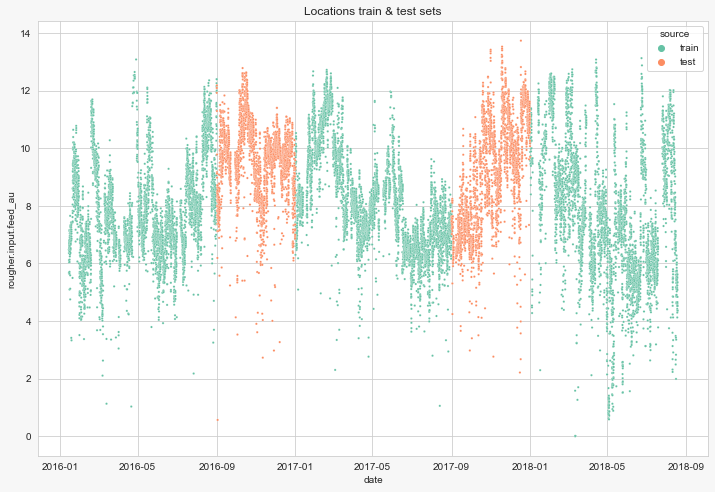

In [19]:
df_train['source'] = 'train'
df_test['source'] = 'test'

t = pd.concat([df_train[['date','rougher.input.feed_au','source']], df_test[['date','rougher.input.feed_au', 'source']]], ignore_index=True)

ax = sns.scatterplot(data=t, x='date', y='rougher.input.feed_au', hue='source', s=5)
ax.set_title('Locations train & test sets')
plt.show()

#### Conclusions

We have prepared transformers for processing outliers, zeros, omissions and replacing them with similar values.

## Analysis

### Concentration of metals (Au, Ag, Pb) change at different stages of purification

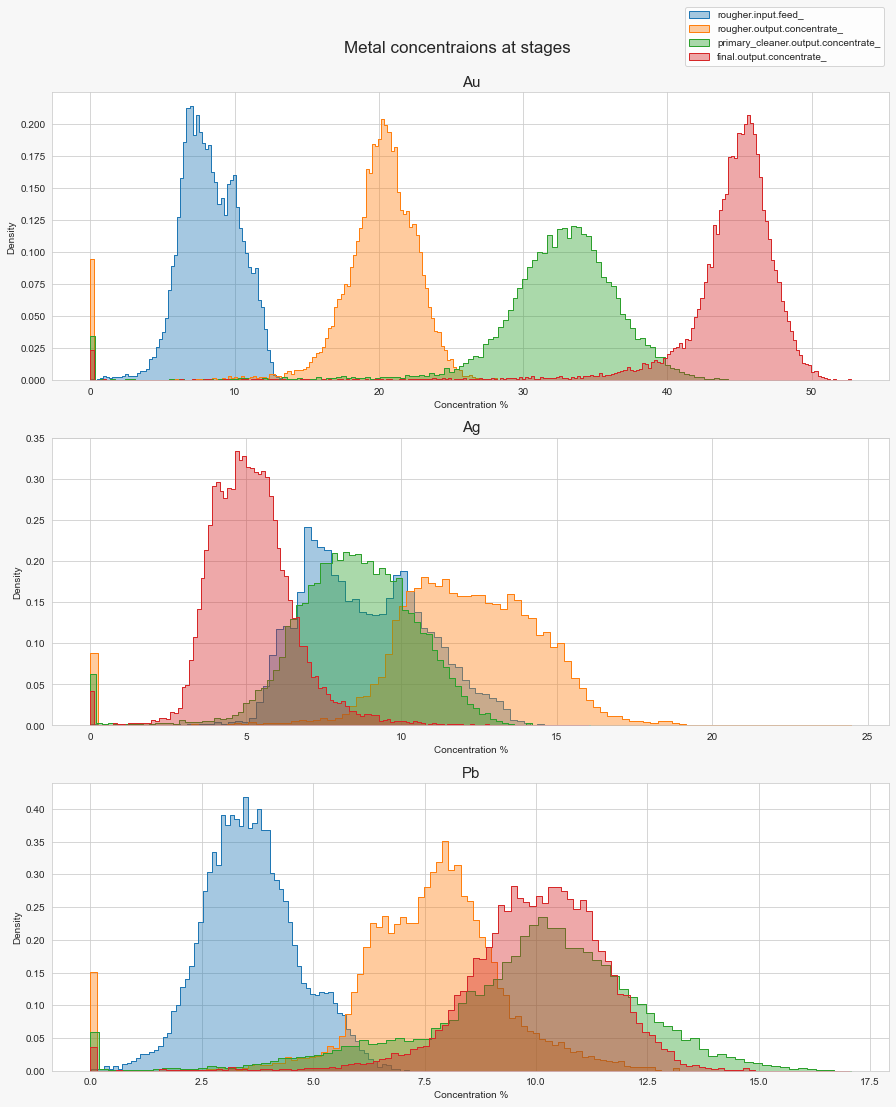

In [20]:
df=df_full
steps = [
    'rougher.input.feed_',
    'rougher.output.concentrate_',
    'primary_cleaner.output.concentrate_',
    'final.output.concentrate_',
]
metals = ['Au', 'Ag', 'Pb']

fig = plt.figure(figsize=(15,18))
    
i = 0
for metal in metals:
    i += 1
    ax = plt.subplot(3,1, i)
    s = 0
    for step in steps:
        
        sns.histplot( data=df[step + metal.lower()]
                        , alpha=0.4
                        , element='step'
                        , stat='density'
                        , ax = ax
                        , legend=False
                        , color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][s]

        );
        s += 1
    ax.set(xlabel="Concentration %", ylabel="Density")
    ax.set_title(metal, fontsize=15)
    
fig.suptitle("Metal concentraions at stages", fontsize=17, y=0.92)
fig.legend(steps, loc='upper right', bbox_to_anchor=(0.9, 0.95))
    

#### Conclusions
We were convinced that from stage to stage the concentration of Au in the ore increases, starting from 7% and ending with 45%.
The concentration of Ag, on the contrary, decreased. But the concentration of Pb has increased, but remains not particularly high (about 10%)

Abnormal zeros are visible. Transformers have been prepared to deal with them

### Distributions of raw material pellets in the training and test samples

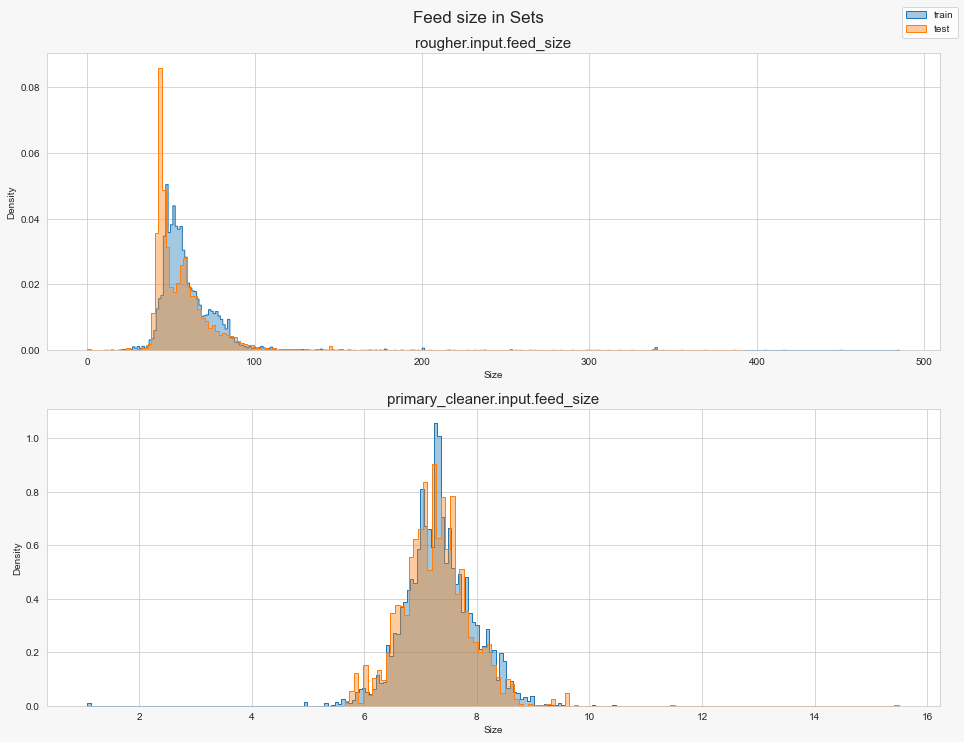

In [21]:
colnames = ['rougher.input.feed_size', 'primary_cleaner.input.feed_size']

    
fig = plt.figure(figsize=(16,6*len(colnames)))
   
i = 0
for col in colnames:
    i += 1
    ax = plt.subplot(2, 1, i)
    s=0
    for df in df_train, df_test:
        s += 1

        sns.histplot( data=df[col]
                    , alpha=0.4
                    , element='step'
                    , stat='density'
                    , ax = ax
                    , legend=False
                    , color = ['#1f77b4', '#ff7f0e'][s-1]

        );

    ax.set(xlabel="Size", ylabel="Density")
    ax.set_title(col, fontsize=15)
    
fig.suptitle("Feed size in Sets", fontsize=17, y=0.93)
fig.legend(['train', 'test'], loc='upper right', bbox_to_anchor=(0.92, 0.94))

#### Conclusions

The input sizes for train and test have the same distribution in the ore, which allows us to leave the hypothesis of similar characteristics of train and set, i.e. it is permissible to build a model on train and test on test

Let's test the hypothesis of equality of averages `rougher.input.feed_size` in train and test, as well as the hypothesis of equality of averages `primary_cleaner.input.feed_size` in train and test

In [22]:
from scipy import stats as st

In [23]:
for colname in ['rougher.input.feed_size', 'primary_cleaner.input.feed_size']:
    print('\n\nWe test the hypothesis of equality of averages in distributions\n----   ', colname,'   ----')
    results = st.ttest_ind(
        df_train[colname].dropna(), 
        df_test[colname].dropna(), 
        equal_var = False
    )

    alpha = 0.05
    print('p-value: ', results.pvalue)
    if alpha > results.pvalue:
        print('The hypothesis H0 of equality of averages is REJECTED. The hypothesis H1 about the difference of averages is accepted')
    else:
        print('The hypothesis H0 of equality of averages could NOT be rejected.')



We test the hypothesis of equality of averages in distributions
----    rougher.input.feed_size    ----
p-value:  1.5360283753498916e-37
The hypothesis H0 of equality of averages is REJECTED. The hypothesis H1 about the difference of averages is accepted


We test the hypothesis of equality of averages in distributions
----    primary_cleaner.input.feed_size    ----
p-value:  1.3721938409942596e-08
The hypothesis H0 of equality of averages is REJECTED. The hypothesis H1 about the difference of averages is accepted


### The total concentration of all substances at different stages

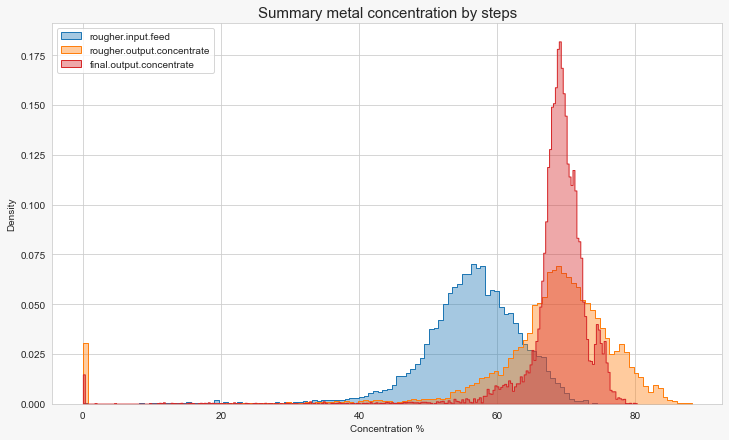

In [24]:
df = df_train
steps = [
    'rougher.input.feed',
    'rougher.output.concentrate',
    'final.output.concentrate',
]
metals = ['_au', '_ag', '_pb', '_sol']

fig = plt.figure(figsize=(12,7))
    

ax = plt.subplot(1,1, 1)
s = 0
for step in steps:

    sns.histplot( data=df.loc[:,[step + x for x in metals]].sum(axis=1)
                    , alpha=0.4
                    , element='step'
                    , stat='density'
                    , ax = ax
                    , legend=False
                    , color = ['#1f77b4', '#ff7f0e', '#d62728'][s]
    );
    s += 1
ax.set(xlabel="Concentration %", ylabel="Density")
ax.set_title('Summary metal concentration by steps', fontsize=15)
ax.legend(steps, loc='upper left')



Abnormal zeros are visible. Transformers have been prepared to deal with them

## Model

$$\mathit{sMAPE} = \frac{1}{N} \sum\limits _{i = 1} ^{N} \frac{\left| y_i - \hat{y}_i \right|}{\left( \left| y_i \right| + \left|\hat{y}_i \right| \right) / 2} \times 100\%$$

$$\mathit{resulting\ sMAPE} = 25\% \times \mathit{sMAPE}\left( \mathit{rougher} \right) + 75\% \times \mathit{sMAPE} \left( \mathit{final} \right)$$

In [25]:
def sMAPE(t, p):
    return np.mean(abs(t - p)/(abs(t)+abs(p))) * 2

def resulting_smape(true_rougher, pred_rougher, true_final, pred_final):
    return 0.25 * sMAPE(true_rougher, pred_rougher) + 0.75 * sMAPE(true_final, pred_final)

smape_scorer = make_scorer(sMAPE,greater_is_better=False)

# Check: should be 0.2071262071262071
sMAPE(pd.Series([1, 2, 3]), pd.Series([1.2, 1.5, 3.5]))

0.2071262071262071

In [26]:
def custom_estimator(transformers, estimator):
    ppline_arr=[]
    ppline_arr.append(('TT',TargetTransformer))
    ppline_arr.append(('IT',InputTransformer()))
    
    if estimator == 'DUMMY':
        estm = DummyRegressor()
    elif estimator == 'LinR':
        estm = LinearRegression(n_jobs=-1)
    elif estimator == 'GBR':
        estm = GradientBoostingRegressor(random_state=RANDOM_STATE)
    elif estimator == 'RFR':
        estm = RandomForestRegressor(random_state=RANDOM_STATE)
    elif estimator == 'HR':
        estm = HuberRegressor()
    elif estimator == 'PAR':
        estm = PassiveAggressiveRegressor(random_state=RANDOM_STATE)
    elif estimator == 'BAG':
        estm = BaggingRegressor(n_jobs=-1, random_state=RANDOM_STATE)
    elif estimator == 'HIST':
        estm = HistGradientBoostingRegressor(random_state=RANDOM_STATE)
    elif estimator == 'ADA':
        estm = AdaBoostRegressor(random_state=RANDOM_STATE)
    elif estimator == 'ARD':
        estm = ARDRegression()
    elif estimator == 'BR':
        estm = BayesianRidge()
    elif estimator == 'SGD':
        estm = SGDRegressor(random_state=RANDOM_STATE)
    elif estimator == 'ELASTIC':
        estm = ElasticNet(random_state=RANDOM_STATE)
    
    
    for transformer in transformers:
        if transformer == 'RUS':
            trns = RandomUnderSampler(random_state=RANDOM_STATE)
        elif transformer == 'ENN':
            trns = EditedNearestNeighbours(n_jobs=-1)
        elif transformer == 'AllKNN':
            trns = AllKNN(n_jobs=-1)
        elif transformer == 'TL':
            trns = TomekLinks(n_jobs=-1)
        elif transformer == 'SMOTE':
            trns = SMOTE(random_state=RANDOM_STATE)
        elif transformer == 'ADASYN':
            trns = ADASYN(random_state=RANDOM_STATE)
        elif transformer == 'ROS':
            trns = RandomOverSampler(random_state=RANDOM_STATE)
        elif transformer == 'RS':
            trns = RobustScaler()
        elif transformer == 'SS':
            trns = StandardScaler()
        
        if transformer != 'NONE':
            ppline_arr.append((transformer,trns))
    
    ppline_arr.append(('estimator',estm))

    return Pipeline(ppline_arr)



Starting the optimization of hyperparameters.

In [27]:
%%time

def objective(trial):
    """
    Cross-validation with current hyperparameters

    :params: hyperparameters
    :pipeline: model
    :X_train: feature matrix
    :y_train: target vector
    :return: average sMAPE on cross validation
    """ 

    
    
    pipeline = custom_estimator(transformers=transformers, estimator=estimator)
    params = {}
    
    # the zero iteration with default parameters
    if trial.number > 0:
        if estimator in ['RFR', 'GBR']:
            params = {
                 'estimator__criterion': trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error', 'mse', 'mae'])
                 , 'estimator__n_estimators': trial.suggest_int(name='n_estimators', low=10, high=200, step=1, log=True)
                 , 'estimator__max_depth': trial.suggest_int(name='max_depth', low=2, high=30, step=1, log=False)
                 , 'estimator__min_samples_leaf': trial.suggest_int(name='min_samples_leaf', low=1, high=30, step=1, log=False)
            }
            if estimator == 'GBR':
                params['estimator__loss'] = trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'huber'])
                params['estimator__learning_rate'] = trial.suggest_float(name='learning_rate', low=0.1, high=0.3, step=0.01, log=False)
                params['estimator__subsample'] = 0.5  #trial.suggest_float(name='subsample', low=0.3, high=0.99, step=0.01, log=False)
        elif estimator == 'DUMMY':
            params = {
                 'estimator__strategy': trial.suggest_categorical('strategy', ['mean', 'median'])
            }
        elif estimator == 'BAG':
            params = {
                 'estimator__n_estimators': trial.suggest_int(name='n_estimators', low=10, high=50, step=1, log=True)
                , 'estimator__max_samples': trial.suggest_int(name='max_samples', low=1, high=5, step=1, log=False)
                , 'estimator__max_features': trial.suggest_int(name='max_features', low=1, high=7, step=1, log=False)
            }
        elif estimator == 'HIST':
            params = {
                 'estimator__loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'poisson'])
                , 'estimator__learning_rate': trial.suggest_float(name='learning_rate', low=0.1, high=0.3, step=0.01, log=False)
                , 'estimator__max_leaf_nodes': trial.suggest_int(name='max_leaf_nodes', low=31, high=101, step=1, log=False)
#                 , 'estimator__max_depth': trial.suggest_int(name='max_depth', low=2, high=100, step=1, log=True)
            }
        elif estimator == 'ADA':
            params = {
                 'estimator__loss': trial.suggest_categorical('loss', ['linear', 'square', 'exponential'])
                , 'estimator__learning_rate': trial.suggest_float(name='learning_rate', low=0.1, high=0.3, step=0.01, log=False)
                , 'estimator__n_estimators': trial.suggest_int(name='n_estimators', low=10, high=50, step=1, log=True)
#                 , 'estimator__max_depth': trial.suggest_int(name='max_depth', low=2, high=100, step=1, log=True)
            }
        elif estimator == 'ELASTIC':
            
            params = {
                 'estimator__l1_ratio': trial.suggest_float(name='l1_ratio', low=0.001, high=0.999, step=0.001, log=False)
            }
                 
    
    # set hyper params   
    pipeline.set_params(**params)

    # KFold for cross validation
    kf = KFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)

    # cross validation 
    score = cross_val_score(estimator=pipeline, X=X, y=y, 
                            scoring=smape_scorer, cv=kf, n_jobs=-1)

    # return results for Trials()
    return   score.mean()
# ======<<<<======<<<<======<<<<======<<<<======<<<<======<<<<======<<<<
if True: # FALSE in order not to wait hours every time for recalculation.
# ======<<<<======<<<<======<<<<======<<<<======<<<<======<<<<======<<<<
    for  step in ['rougher', 'final']:
        print('\n\n\n----------------------------------\n---------  ',
              step,
              ' -------------\n----------------------------------')

        X = X_['train'][step]
        y = y_['train'][step]

        best_score_ = -10000
        log_history = {}
#         ['DUMMY', 'LinR', 'PAR', 'BAG', 'HIST', 'ADA', 'ARD', 'BR', 'SGD', 'ELASTIC']
        for est in ['DUMMY', 'LinR',  'HIST', 'ADA', 'ELASTIC']:
            t1 = time.time()
            sampler = optuna.samplers.TPESampler(seed=10)
            if est in ['RFR', 'GBR','BAG', 'HIST', 'ADA', 'ELASTIC']:
                n_attempts = 100
            elif est == 'DUMMY':
                n_attempts = 5
            else:
                n_attempts = 1

            transformers=['SS']
            estimator=est

            study = optuna.create_study(sampler=sampler, direction="maximize")
            study.optimize(objective, n_trials=n_attempts, timeout=60*60, n_jobs=-1)

            if best_score_ <= study.best_trial.values[0]:
                best_params_ = study.best_trial.params
                best_estimator_ = estimator
                best_score_ = study.best_trial.values[0]
            log_history.update({estimator:{
                'score': study.best_trial.values[0],
                'params': study.best_trial.params,
                'time': time.time() - t1
            }})
        print(log_history)
        print ('BEST is', best_estimator_, 'score=', best_score_ , 'params=',  best_params_)                        



[I 2022-10-23 20:44:08,029] A new study created in memory with name: no-name-181f39f6-c827-49d5-84b2-6912f53550f0





----------------------------------
---------   rougher  -------------
----------------------------------


[I 2022-10-23 20:44:13,406] Trial 2 finished with value: -0.1134981196168162 and parameters: {'strategy': 'median'}. Best is trial 2 with value: -0.1134981196168162.
[I 2022-10-23 20:44:13,619] Trial 1 finished with value: -0.1134981196168162 and parameters: {'strategy': 'median'}. Best is trial 2 with value: -0.1134981196168162.
[I 2022-10-23 20:44:13,681] Trial 4 finished with value: -0.11409641105667706 and parameters: {'strategy': 'mean'}. Best is trial 2 with value: -0.1134981196168162.
[I 2022-10-23 20:44:14,115] Trial 0 finished with value: -0.11409641105667706 and parameters: {}. Best is trial 2 with value: -0.1134981196168162.
[I 2022-10-23 20:44:14,256] Trial 3 finished with value: -0.1134981196168162 and parameters: {'strategy': 'median'}. Best is trial 2 with value: -0.1134981196168162.
[I 2022-10-23 20:44:14,259] A new study created in memory with name: no-name-0b6e8128-b362-468f-bc15-004928d3d814
[I 2022-10-23 20:44:15,369] Trial 0 finished with value: -0.0919655035452823

[I 2022-10-23 20:44:47,825] Trial 31 finished with value: -0.07125348315854686 and parameters: {'loss': 'squared_error', 'learning_rate': 0.1, 'max_leaf_nodes': 96}. Best is trial 31 with value: -0.07125348315854686.
[I 2022-10-23 20:44:49,377] Trial 32 finished with value: -0.0715758692588132 and parameters: {'loss': 'absolute_error', 'learning_rate': 0.1, 'max_leaf_nodes': 100}. Best is trial 31 with value: -0.07125348315854686.
[I 2022-10-23 20:44:50,573] Trial 33 finished with value: -0.0715942600931532 and parameters: {'loss': 'absolute_error', 'learning_rate': 0.1, 'max_leaf_nodes': 98}. Best is trial 31 with value: -0.07125348315854686.
[I 2022-10-23 20:44:51,948] Trial 34 finished with value: -0.07159112780791459 and parameters: {'loss': 'absolute_error', 'learning_rate': 0.11, 'max_leaf_nodes': 100}. Best is trial 31 with value: -0.07125348315854686.
[I 2022-10-23 20:44:53,539] Trial 35 finished with value: -0.07166560043503686 and parameters: {'loss': 'absolute_error', 'learn

[I 2022-10-23 20:45:26,344] Trial 67 finished with value: -0.07170073154043526 and parameters: {'loss': 'squared_error', 'learning_rate': 0.14, 'max_leaf_nodes': 87}. Best is trial 31 with value: -0.07125348315854686.
[I 2022-10-23 20:45:26,403] Trial 66 finished with value: -0.07150016294276557 and parameters: {'loss': 'squared_error', 'learning_rate': 0.14, 'max_leaf_nodes': 86}. Best is trial 31 with value: -0.07125348315854686.
[I 2022-10-23 20:45:27,566] Trial 68 finished with value: -0.07151377484573969 and parameters: {'loss': 'squared_error', 'learning_rate': 0.14, 'max_leaf_nodes': 90}. Best is trial 31 with value: -0.07125348315854686.
[I 2022-10-23 20:45:28,622] Trial 69 finished with value: -0.07151377484573969 and parameters: {'loss': 'squared_error', 'learning_rate': 0.14, 'max_leaf_nodes': 90}. Best is trial 31 with value: -0.07125348315854686.
[I 2022-10-23 20:45:29,636] Trial 70 finished with value: -0.07151377484573969 and parameters: {'loss': 'squared_error', 'learni

[I 2022-10-23 20:46:07,869] Trial 2 finished with value: -0.09163559092065889 and parameters: {'loss': 'exponential', 'learning_rate': 0.2, 'n_estimators': 10}. Best is trial 2 with value: -0.09163559092065889.
[I 2022-10-23 20:46:09,862] Trial 3 finished with value: -0.09750418637646346 and parameters: {'loss': 'linear', 'learning_rate': 0.15000000000000002, 'n_estimators': 42}. Best is trial 2 with value: -0.09163559092065889.
[I 2022-10-23 20:46:13,154] Trial 4 finished with value: -0.09795061996526093 and parameters: {'loss': 'exponential', 'learning_rate': 0.26, 'n_estimators': 36}. Best is trial 2 with value: -0.09163559092065889.
[I 2022-10-23 20:46:15,824] Trial 8 finished with value: -0.09178028537452043 and parameters: {'loss': 'linear', 'learning_rate': 0.22, 'n_estimators': 10}. Best is trial 2 with value: -0.09163559092065889.
[I 2022-10-23 20:46:16,249] Trial 5 finished with value: -0.09906676414720902 and parameters: {'loss': 'exponential', 'learning_rate': 0.22, 'n_esti

[I 2022-10-23 20:46:45,794] Trial 39 finished with value: -0.09494946118474445 and parameters: {'loss': 'square', 'learning_rate': 0.18, 'n_estimators': 18}. Best is trial 2 with value: -0.09163559092065889.
[I 2022-10-23 20:46:46,102] Trial 40 finished with value: -0.09507967137798591 and parameters: {'loss': 'square', 'learning_rate': 0.19, 'n_estimators': 18}. Best is trial 2 with value: -0.09163559092065889.
[I 2022-10-23 20:46:46,500] Trial 41 finished with value: -0.09274819071454728 and parameters: {'loss': 'square', 'learning_rate': 0.1, 'n_estimators': 18}. Best is trial 2 with value: -0.09163559092065889.
[I 2022-10-23 20:46:46,661] Trial 42 finished with value: -0.09209189542850865 and parameters: {'loss': 'linear', 'learning_rate': 0.19, 'n_estimators': 12}. Best is trial 2 with value: -0.09163559092065889.
[I 2022-10-23 20:46:48,540] Trial 43 finished with value: -0.09209189542850865 and parameters: {'loss': 'linear', 'learning_rate': 0.19, 'n_estimators': 12}. Best is tri

[I 2022-10-23 20:47:15,356] Trial 74 finished with value: -0.09168752101809681 and parameters: {'loss': 'exponential', 'learning_rate': 0.12000000000000001, 'n_estimators': 15}. Best is trial 62 with value: -0.09141985829941165.
[I 2022-10-23 20:47:17,298] Trial 76 finished with value: -0.09187608493764671 and parameters: {'loss': 'exponential', 'learning_rate': 0.12000000000000001, 'n_estimators': 11}. Best is trial 62 with value: -0.09141985829941165.
[I 2022-10-23 20:47:17,670] Trial 77 finished with value: -0.09187608493764671 and parameters: {'loss': 'exponential', 'learning_rate': 0.12000000000000001, 'n_estimators': 11}. Best is trial 62 with value: -0.09141985829941165.
[I 2022-10-23 20:47:17,903] Trial 78 finished with value: -0.09187608493764671 and parameters: {'loss': 'exponential', 'learning_rate': 0.12000000000000001, 'n_estimators': 11}. Best is trial 62 with value: -0.09141985829941165.
[I 2022-10-23 20:47:18,837] Trial 79 finished with value: -0.09187608493764671 and p

[I 2022-10-23 20:47:48,153] Trial 13 finished with value: -0.09642940792234715 and parameters: {'l1_ratio': 0.393}. Best is trial 12 with value: -0.09565448990435307.
[I 2022-10-23 20:47:48,482] Trial 11 finished with value: -0.09608441415935447 and parameters: {'l1_ratio': 0.232}. Best is trial 12 with value: -0.09565448990435307.
[I 2022-10-23 20:47:49,224] Trial 16 finished with value: -0.0961393283149421 and parameters: {'l1_ratio': 0.261}. Best is trial 12 with value: -0.09565448990435307.
[I 2022-10-23 20:47:49,874] Trial 17 finished with value: -0.09612191814998118 and parameters: {'l1_ratio': 0.252}. Best is trial 12 with value: -0.09565448990435307.
[I 2022-10-23 20:47:51,047] Trial 19 finished with value: -0.09704319318525996 and parameters: {'l1_ratio': 0.609}. Best is trial 12 with value: -0.09565448990435307.
[I 2022-10-23 20:47:51,064] Trial 18 finished with value: -0.09721789721965678 and parameters: {'l1_ratio': 0.7010000000000001}. Best is trial 12 with value: -0.09565

[I 2022-10-23 20:48:18,308] Trial 60 finished with value: -0.09598346437879218 and parameters: {'l1_ratio': 0.17500000000000002}. Best is trial 32 with value: -0.09563053361187124.
[I 2022-10-23 20:48:19,740] Trial 62 finished with value: -0.09600071010935521 and parameters: {'l1_ratio': 0.184}. Best is trial 32 with value: -0.09563053361187124.
[I 2022-10-23 20:48:19,772] Trial 61 finished with value: -0.09599682902433476 and parameters: {'l1_ratio': 0.182}. Best is trial 32 with value: -0.09563053361187124.
[I 2022-10-23 20:48:20,479] Trial 63 finished with value: -0.09603203268492516 and parameters: {'l1_ratio': 0.202}. Best is trial 32 with value: -0.09563053361187124.
[I 2022-10-23 20:48:21,441] Trial 64 finished with value: -0.09604220157713986 and parameters: {'l1_ratio': 0.20800000000000002}. Best is trial 32 with value: -0.09563053361187124.
[I 2022-10-23 20:48:22,283] Trial 65 finished with value: -0.09581737938511962 and parameters: {'l1_ratio': 0.095}. Best is trial 32 with

{'DUMMY': {'score': -0.1134981196168162, 'params': {'strategy': 'median'}, 'time': 6.230154752731323}, 'LinR': {'score': -0.09196550354528234, 'params': {}, 'time': 1.1129646301269531}, 'HIST': {'score': -0.07125348315854686, 'params': {'loss': 'squared_error', 'learning_rate': 0.1, 'max_leaf_nodes': 96}, 'time': 105.03755784034729}, 'ADA': {'score': -0.09111744434374952, 'params': {'loss': 'exponential', 'learning_rate': 0.14, 'n_estimators': 15}, 'time': 95.92143630981445}, 'ELASTIC': {'score': -0.09562873043069439, 'params': {'l1_ratio': 0.001}, 'time': 66.91888499259949}}
BEST is HIST score= -0.07125348315854686 params= {'loss': 'squared_error', 'learning_rate': 0.1, 'max_leaf_nodes': 96}



----------------------------------
---------   final  -------------
----------------------------------


[I 2022-10-23 20:48:52,670] Trial 3 finished with value: -0.1108043073629385 and parameters: {'strategy': 'mean'}. Best is trial 3 with value: -0.1108043073629385.
[I 2022-10-23 20:48:52,778] Trial 1 finished with value: -0.1108043073629385 and parameters: {'strategy': 'mean'}. Best is trial 3 with value: -0.1108043073629385.
[I 2022-10-23 20:48:55,360] Trial 2 finished with value: -0.1108043073629385 and parameters: {'strategy': 'mean'}. Best is trial 3 with value: -0.1108043073629385.
[I 2022-10-23 20:48:55,376] Trial 0 finished with value: -0.1108043073629385 and parameters: {}. Best is trial 3 with value: -0.1108043073629385.
[I 2022-10-23 20:48:55,468] Trial 4 finished with value: -0.11040969616799459 and parameters: {'strategy': 'median'}. Best is trial 4 with value: -0.11040969616799459.
[I 2022-10-23 20:48:55,471] A new study created in memory with name: no-name-66990e93-d700-4478-8e8e-4c7365d20993
[I 2022-10-23 20:48:59,374] Trial 0 finished with value: -0.08963665868665102 an

[I 2022-10-23 20:50:44,043] Trial 31 finished with value: -0.06802541508999685 and parameters: {'loss': 'absolute_error', 'learning_rate': 0.1, 'max_leaf_nodes': 98}. Best is trial 31 with value: -0.06802541508999685.
[I 2022-10-23 20:50:49,398] Trial 32 finished with value: -0.06825185709605779 and parameters: {'loss': 'absolute_error', 'learning_rate': 0.11, 'max_leaf_nodes': 99}. Best is trial 31 with value: -0.06802541508999685.
[I 2022-10-23 20:50:55,774] Trial 33 finished with value: -0.06832443983045855 and parameters: {'loss': 'absolute_error', 'learning_rate': 0.1, 'max_leaf_nodes': 100}. Best is trial 31 with value: -0.06802541508999685.
[I 2022-10-23 20:50:56,176] Trial 34 finished with value: -0.06806753815444665 and parameters: {'loss': 'absolute_error', 'learning_rate': 0.15000000000000002, 'max_leaf_nodes': 100}. Best is trial 31 with value: -0.06802541508999685.
[I 2022-10-23 20:50:58,611] Trial 35 finished with value: -0.06817189239997834 and parameters: {'loss': 'squa

[I 2022-10-23 20:52:47,633] Trial 66 finished with value: -0.06821137722173279 and parameters: {'loss': 'absolute_error', 'learning_rate': 0.19, 'max_leaf_nodes': 95}. Best is trial 41 with value: -0.06792598115458692.
[I 2022-10-23 20:52:48,914] Trial 67 finished with value: -0.06821137722173279 and parameters: {'loss': 'absolute_error', 'learning_rate': 0.19, 'max_leaf_nodes': 95}. Best is trial 41 with value: -0.06792598115458692.
[I 2022-10-23 20:52:53,532] Trial 68 finished with value: -0.06823051902324008 and parameters: {'loss': 'absolute_error', 'learning_rate': 0.18, 'max_leaf_nodes': 95}. Best is trial 41 with value: -0.06792598115458692.
[I 2022-10-23 20:52:57,345] Trial 69 finished with value: -0.06809939222572964 and parameters: {'loss': 'absolute_error', 'learning_rate': 0.17, 'max_leaf_nodes': 95}. Best is trial 41 with value: -0.06792598115458692.
[I 2022-10-23 20:52:59,122] Trial 70 finished with value: -0.06848687278558795 and parameters: {'loss': 'absolute_error', 'l

[I 2022-10-23 20:54:46,089] Trial 0 finished with value: -0.09708634430135485 and parameters: {}. Best is trial 2 with value: -0.09164545304356847.
[I 2022-10-23 20:54:46,113] Trial 3 finished with value: -0.09204589864970515 and parameters: {'loss': 'exponential', 'learning_rate': 0.11, 'n_estimators': 10}. Best is trial 2 with value: -0.09164545304356847.
[I 2022-10-23 20:54:57,657] Trial 1 finished with value: -0.09344546703535477 and parameters: {'loss': 'square', 'learning_rate': 0.24000000000000002, 'n_estimators': 15}. Best is trial 2 with value: -0.09164545304356847.
[I 2022-10-23 20:55:03,321] Trial 4 finished with value: -0.09003192485173428 and parameters: {'loss': 'exponential', 'learning_rate': 0.22, 'n_estimators': 22}. Best is trial 4 with value: -0.09003192485173428.
[I 2022-10-23 20:55:05,745] Trial 5 finished with value: -0.09124372503423048 and parameters: {'loss': 'exponential', 'learning_rate': 0.28, 'n_estimators': 26}. Best is trial 4 with value: -0.0900319248517

[I 2022-10-23 20:56:35,739] Trial 38 finished with value: -0.09049054900979847 and parameters: {'loss': 'exponential', 'learning_rate': 0.26, 'n_estimators': 18}. Best is trial 36 with value: -0.08993191993910801.
[I 2022-10-23 20:56:36,366] Trial 40 finished with value: -0.09049054900979847 and parameters: {'loss': 'exponential', 'learning_rate': 0.26, 'n_estimators': 18}. Best is trial 36 with value: -0.08993191993910801.
[I 2022-10-23 20:56:37,492] Trial 39 finished with value: -0.09067937439087795 and parameters: {'loss': 'exponential', 'learning_rate': 0.26, 'n_estimators': 19}. Best is trial 36 with value: -0.08993191993910801.
[I 2022-10-23 20:56:44,652] Trial 41 finished with value: -0.08991095905908145 and parameters: {'loss': 'exponential', 'learning_rate': 0.21000000000000002, 'n_estimators': 19}. Best is trial 41 with value: -0.08991095905908145.
[I 2022-10-23 20:56:47,408] Trial 42 finished with value: -0.09067937439087795 and parameters: {'loss': 'exponential', 'learning_

[I 2022-10-23 20:58:20,328] Trial 74 finished with value: -0.09259537058483716 and parameters: {'loss': 'square', 'learning_rate': 0.22, 'n_estimators': 14}. Best is trial 41 with value: -0.08991095905908145.
[I 2022-10-23 20:58:21,571] Trial 75 finished with value: -0.09259537058483716 and parameters: {'loss': 'square', 'learning_rate': 0.22, 'n_estimators': 14}. Best is trial 41 with value: -0.08991095905908145.
[I 2022-10-23 20:58:24,326] Trial 76 finished with value: -0.09259537058483716 and parameters: {'loss': 'square', 'learning_rate': 0.22, 'n_estimators': 14}. Best is trial 41 with value: -0.08991095905908145.
[I 2022-10-23 20:58:26,767] Trial 77 finished with value: -0.09259537058483716 and parameters: {'loss': 'square', 'learning_rate': 0.22, 'n_estimators': 14}. Best is trial 41 with value: -0.08991095905908145.
[I 2022-10-23 20:58:28,536] Trial 78 finished with value: -0.09259537058483716 and parameters: {'loss': 'square', 'learning_rate': 0.22, 'n_estimators': 14}. Best i

[I 2022-10-23 21:00:01,769] Trial 13 finished with value: -0.09329542413608961 and parameters: {'l1_ratio': 0.192}. Best is trial 8 with value: -0.09276338641287381.
[I 2022-10-23 21:00:03,915] Trial 15 finished with value: -0.09390705809793995 and parameters: {'l1_ratio': 0.402}. Best is trial 8 with value: -0.09276338641287381.
[I 2022-10-23 21:00:05,081] Trial 14 finished with value: -0.09492196377253254 and parameters: {'l1_ratio': 0.7010000000000001}. Best is trial 8 with value: -0.09276338641287381.
[I 2022-10-23 21:00:08,846] Trial 16 finished with value: -0.09326454447045335 and parameters: {'l1_ratio': 0.181}. Best is trial 8 with value: -0.09276338641287381.
[I 2022-10-23 21:00:13,534] Trial 18 finished with value: -0.09547675806155759 and parameters: {'l1_ratio': 0.9430000000000001}. Best is trial 8 with value: -0.09276338641287381.
[I 2022-10-23 21:00:14,650] Trial 19 finished with value: -0.09512700367916191 and parameters: {'l1_ratio': 0.782}. Best is trial 8 with value: 

[I 2022-10-23 21:01:42,703] Trial 58 finished with value: -0.09302775414559644 and parameters: {'l1_ratio': 0.10200000000000001}. Best is trial 41 with value: -0.09267013672494773.
[I 2022-10-23 21:01:46,308] Trial 59 finished with value: -0.09307734481158887 and parameters: {'l1_ratio': 0.116}. Best is trial 41 with value: -0.09267013672494773.
[I 2022-10-23 21:01:49,573] Trial 60 finished with value: -0.09304581454062613 and parameters: {'l1_ratio': 0.107}. Best is trial 41 with value: -0.09267013672494773.
[I 2022-10-23 21:01:53,251] Trial 61 finished with value: -0.09307058703087168 and parameters: {'l1_ratio': 0.114}. Best is trial 41 with value: -0.09267013672494773.
[I 2022-10-23 21:01:54,076] Trial 62 finished with value: -0.09304938045904608 and parameters: {'l1_ratio': 0.108}. Best is trial 41 with value: -0.09267013672494773.
[I 2022-10-23 21:01:54,858] Trial 63 finished with value: -0.0930387065101495 and parameters: {'l1_ratio': 0.10500000000000001}. Best is trial 41 with 

{'DUMMY': {'score': -0.11040969616799459, 'params': {'strategy': 'median'}, 'time': 12.221507549285889}, 'LinR': {'score': -0.08963665868665102, 'params': {}, 'time': 3.9065630435943604}, 'HIST': {'score': -0.06792598115458692, 'params': {'loss': 'absolute_error', 'learning_rate': 0.16, 'max_leaf_nodes': 95}, 'time': 323.6080963611603}, 'ADA': {'score': -0.08991095905908145, 'params': {'loss': 'exponential', 'learning_rate': 0.21000000000000002, 'n_estimators': 19}, 'time': 300.8844530582428}, 'ELASTIC': {'score': -0.09267013672494773, 'params': {'l1_ratio': 0.003}, 'time': 225.3527717590332}}
BEST is HIST score= -0.06792598115458692 params= {'loss': 'absolute_error', 'learning_rate': 0.16, 'max_leaf_nodes': 95}
CPU times: total: 40.8 s
Wall time: 19min 1s


The code above finds the optimal parameters of regression algorithms, then we count the scores on the entire train

The GradientBoostingRegressor and RandomForestRegressor models took an extremely long time to execute, so I removed them from consideration. If necessary, you can add to the list of models these models too.

In [28]:
%%time
array_best_={
    'rougher': {        
        'DUMMY': {'score': -0.1134981196168162, 'params': {'strategy': 'median'}, 'time': 7.196115732192993}, 
        'LinR': {'score': -0.09196550354528234, 'params': {}, 'time': 1.114070177078247}, 
        'HIST': {'score': -0.07126247869151836, 'params': {'loss': 'squared_error', 'learning_rate': 0.1, 'max_leaf_nodes': 98}, 'time': 103.51040887832642}, 
        'ADA': {'score': -0.09128516959762767, 'params': {'loss': 'exponential', 'learning_rate': 0.14, 'n_estimators': 14}, 'time': 88.728919506073}, 
        'ELASTIC': {'score': -0.09562873043069439, 'params': {'l1_ratio': 0.001}, 'time': 65.48906135559082}
    },
    'final':{
        'DUMMY': {'score': -0.11040969616799459, 'params': {'strategy': 'median'}, 'time': 12.50610899925232},
        'LinR': {'score': -0.08963665868665102, 'params': {}, 'time': 3.677593469619751}, 
        'HIST': {'score': -0.06793057410374552, 'params': {'loss': 'absolute_error', 'learning_rate': 0.12000000000000001, 'max_leaf_nodes': 97}, 'time': 298.25619292259216}, 
        'ADA': {'score': -0.08950515145350713, 'params': {'loss': 'exponential', 'learning_rate': 0.13, 'n_estimators': 35}, 'time': 327.99543142318726}, 
        'ELASTIC': {'score': -0.09266304472131194, 'params': {'l1_ratio': 0.001}, 'time': 205.26243710517883}
    }
}

for est in ['DUMMY', 'LinR', 'HIST', 'ADA', 'ELASTIC']:
    
    kf = KFold(n_splits=4, shuffle=False
#                , random_state=RANDOM_STATE
              )

    t1 = time.time()
    estimator = est
    pipeline = custom_estimator(transformers=['SS'], estimator=est)
    
    res = []
    for  step in ['rougher', 'final']:
        X = X_['train'][step]
        y = y_['train'][step]
        params = array_best_[step][est]['params']
        params = {'estimator__'+name: v for name, v in params.items()}
        pipeline.set_params(**params)

        pipeline.fit(X, y)
        score = cross_val_score(estimator=pipeline, X=X, y=y, 
                                scoring=smape_scorer, 
                                cv=kf, n_jobs=-1)
        res.append(score.mean())
    res_score = (np.array(res)*np.array([0.25, 0.75])).sum()
    print('estimator', est, 'res_score', -res_score, 'time', time.time() - t1, 'res', res)

estimator DUMMY res_score 0.11680084328621451 time 9.936395168304443 res [-0.12268916542145406, -0.11483806924113467]
estimator LinR res_score 0.11654968921219921 time 10.824496746063232 res [-0.10877784488111761, -0.11914030398922643]
estimator HIST res_score 0.10775607421363313 time 23.773844480514526 res [-0.11989741092536245, -0.10370896197639003]
estimator ADA res_score 0.10928904310701623 time 22.559030294418335 res [-0.11767431955321707, -0.10649395095828262]
estimator ELASTIC res_score 0.10453810443653735 time 8.827657699584961 res [-0.10960654681654912, -0.10284862364320009]
CPU times: total: 2min 22s
Wall time: 1min 15s


The ELASTIC (Elastic Net) model for predicting both target features looks the best on train. It is significantly ahead of DUMMY (10.4% vs. 11.7%). We select it for test.
But for the sake of interest, we will run all the other models on test.

**Important:** the hyper-parameters of the model for `rougher` and `final` could be different, but in our case they almost coincided


In [29]:
%%time

est = 'ELASTIC'
t1 = time.time()
estimator = est
pipeline = custom_estimator(transformers=['SS'], estimator=estimator)

y_pred = {}
y_act = {}
#     N = 20000
for  step in ['rougher', 'final']:
    X_train = X_['train'][step]
    y_train = y_['train'][step]
    X_test = X_['test'][step]

    params = array_best_[step][est]['params']
    params = {'estimator__'+name: v for name, v in params.items()}
    pipeline.set_params(**params)

    y_act[step] = y_['test'][step]

    pipeline.fit(X_train, y_train)
    y_pred[step] = pipeline.predict(X_test)

res = resulting_smape(y_act['rougher'], y_pred['rougher'], y_act['final'], y_pred['final'])
print('estimator', est, 'res', res, 'time', time.time() - t1)

estimator ELASTIC res 0.08684542461623161 time 4.786343812942505
CPU times: total: 13.2 s
Wall time: 4.79 s


On the test the ELASTIC model showed sMAPE 8.7%



## Final Conclusions

During the project, an optimal model was created in order to predict the efficiency coefficient of ore dressing. At the same time, the metric was a symmetric MAPE<br>
When getting acquainted with the data, problems with omissions and with questionable data were identified. These problems were solved by replacing them with neighboring values (according to the formulation of the problem "Neighboring parameters are often similar in time")<br>
When building the model, it was necessary to predict two target features 'rougher.output.recovery', 'final.output.recovery'. For each forecast, its own list of feautures was formed and a model was formed based on those parameters that were available according to the production digital at the time of forecasting the selected feature.<br>
<br>
Models have been tested 
- LinearRegression,
- HistGradientBoostingRegressor,
- AdaBoostRegressor,
- ElasticNet

Previously, the models were normalized using StandartScaler, replacing omissions and zeros in the features with neighboring ones by the KNN method. It also turned out to be effective in the training sample to replace the zeros in target with neighboring values<br>
The process of selecting hyperparameters was carried out by the OPTUNA package with cross-validation. The process was carried out separately for 'rougher' and 'final'<br>
The optimal model turned out to be ElasticNet, which showed a final sMAPE indicator of 10.4% on the training sample, which is lower than DUMMY(median) with an indicator of 11.7%<br>
<br>
On the test sample, the model showed the metric of the final sMAPE 8.7%

## Recommendations

Pay attention to outliers and zeros in the data. Their influence on the quality of the model is extremely high. If eliminate such garbage data, this will significantly improve the model. The error can be improved to 5% or lower if outliers are cut off.
